In [134]:
import pandas as pd
data = pd.read_csv(r'../data/spi_vci_daily.csv').iloc[:, 1:]

/tmp/ipykernel_1142266/73208286.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for idx, df in data.drop(columns={'precp_idx','land_cat','time'}).groupby(['product']):


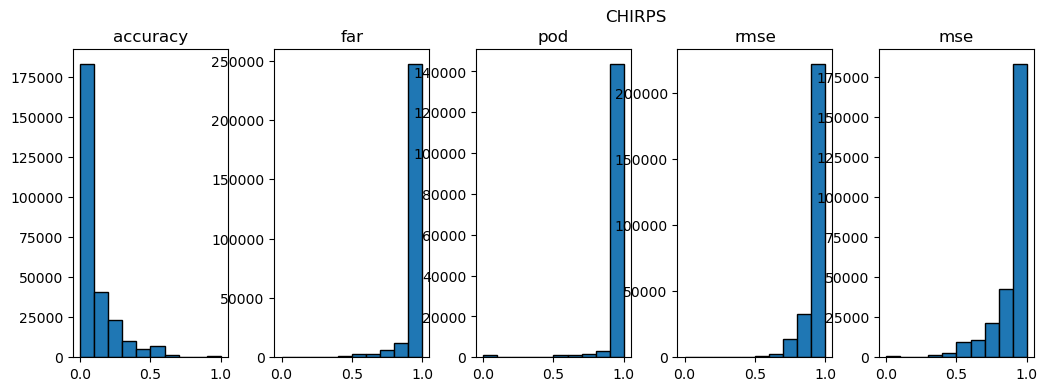

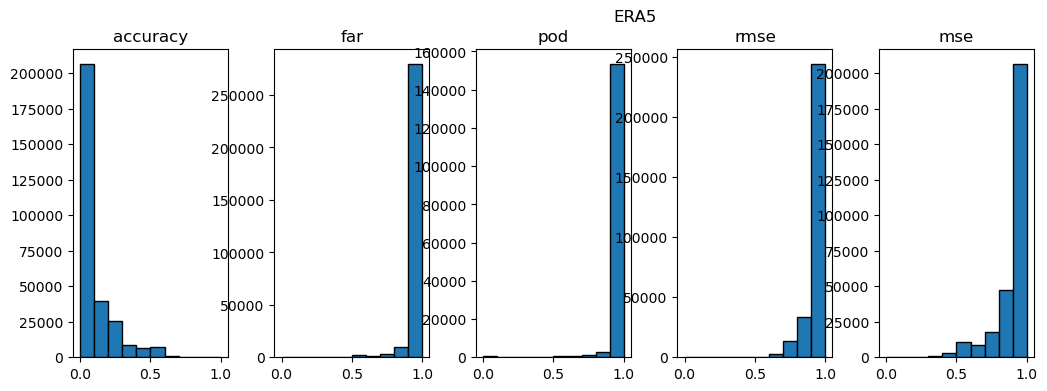

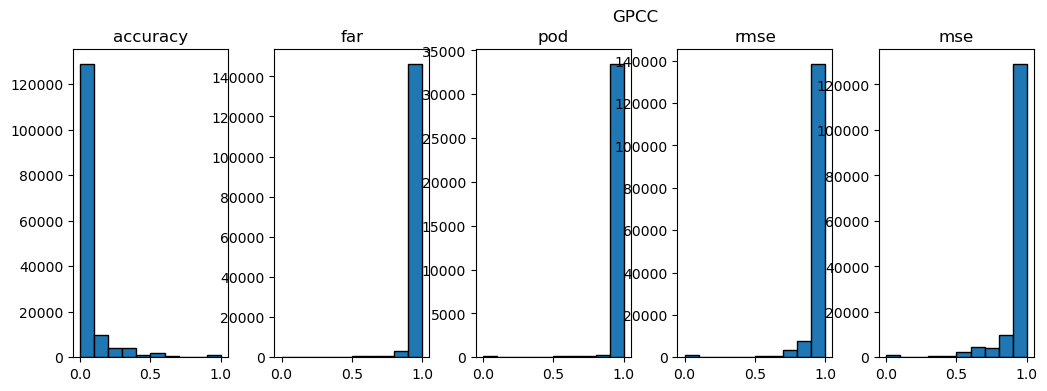

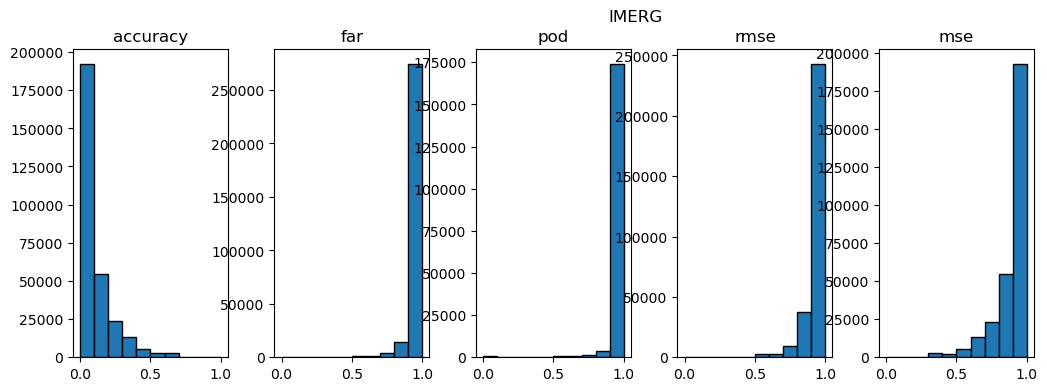

In [2]:
for idx, df in data.drop(columns={'precp_idx','land_cat','time'}).groupby(['product']):
        # plot a hist for each column
    axes = df.hist(layout=(1, 6), figsize=(15, 4), ec='k', grid=False)

    #df.plot(layout=(1, 6), kind='kde', ax=axes, secondary_y=True)

    # extract the figure object from the array of axes
    fig = axes[0][0].get_figure()

    # add the gender as the title
    fig.suptitle(idx)

In [135]:
sub_df = data.loc[data['precp_idx']=="spi_gamma_30"]

In [136]:
import seaborn as sns
df = sub_df.groupby(['description','product']).mean()[['far','pod','accuracy']]
df.style.background_gradient(cmap='Blues')


/tmp/ipykernel_1779641/3295850026.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = sub_df.groupby(['description','product']).mean()[['far','pod','accuracy']]


<Figure size 640x480 with 0 Axes>

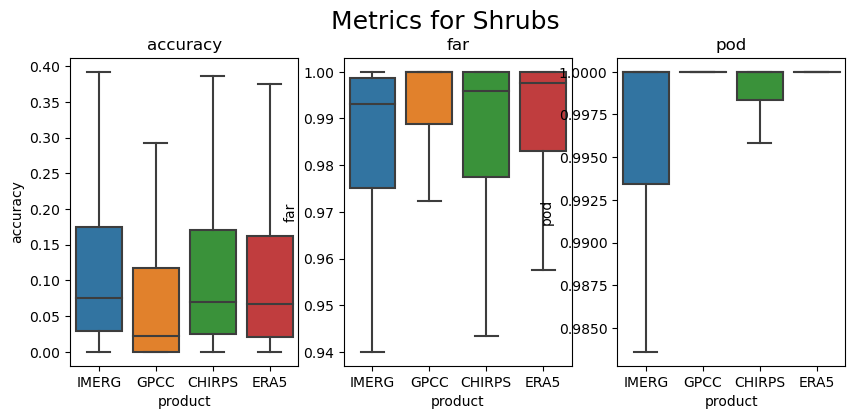

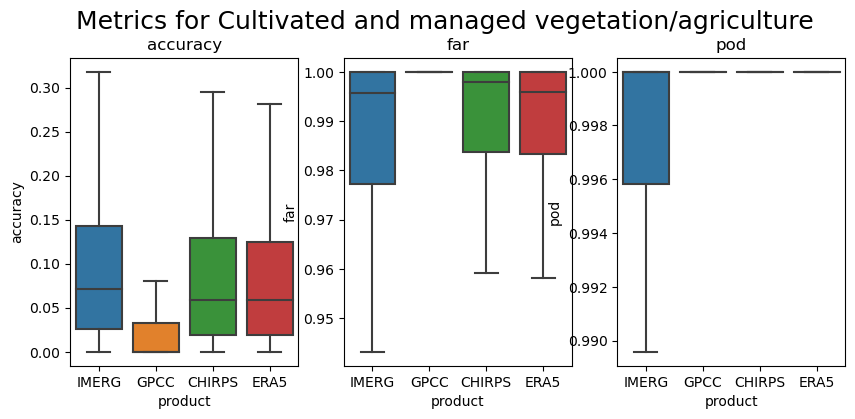

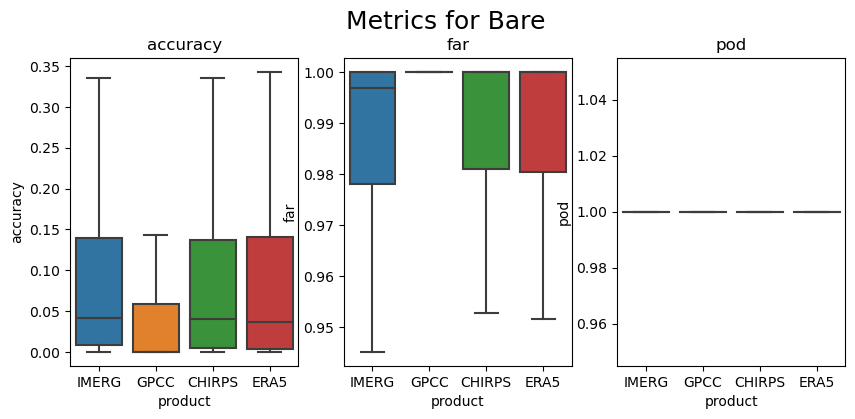

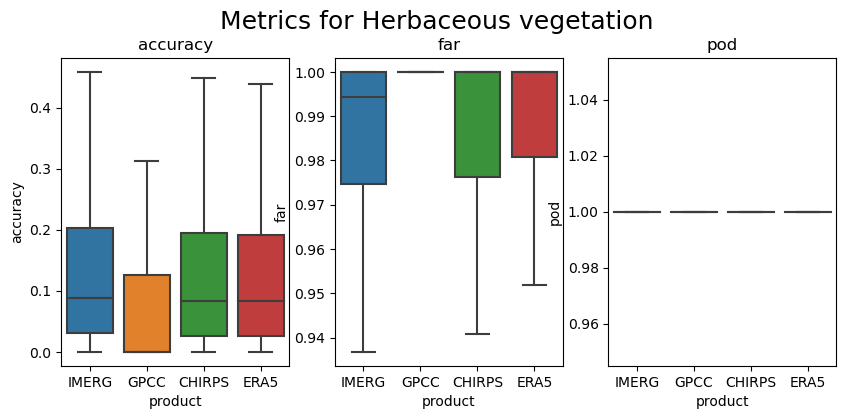

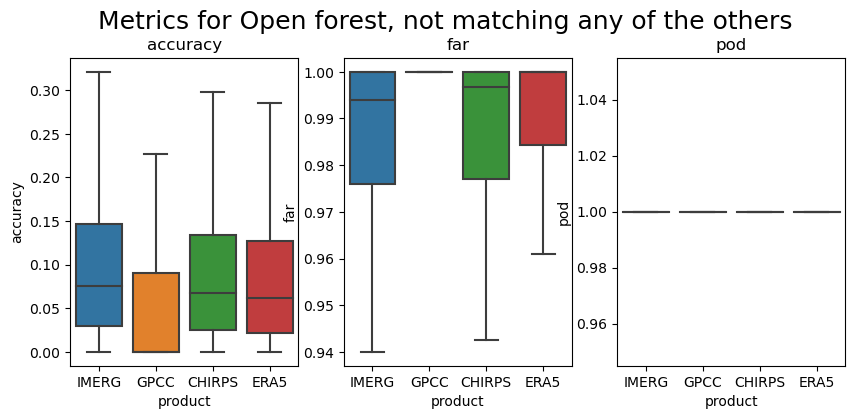

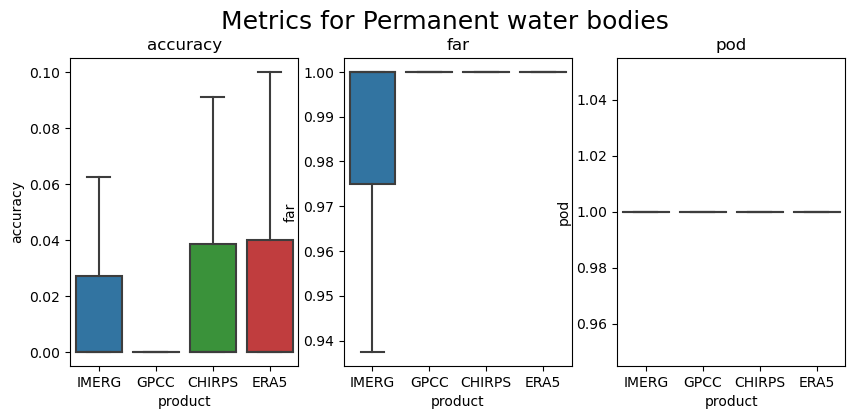

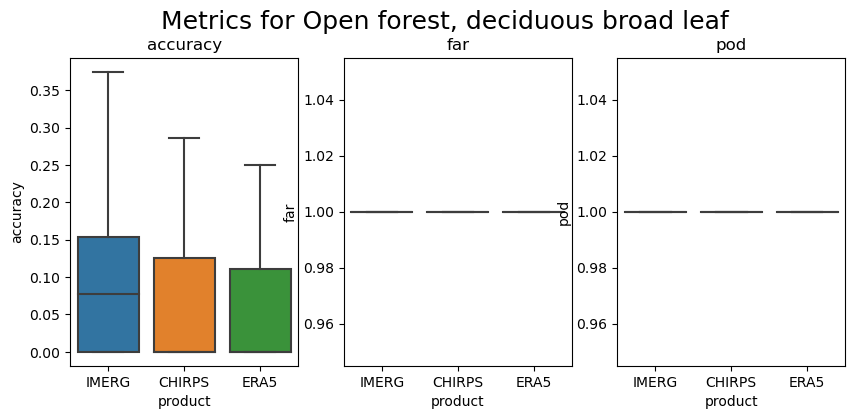

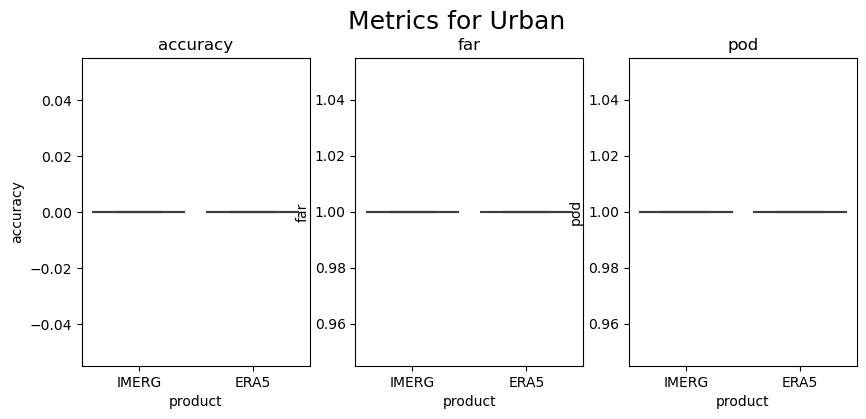

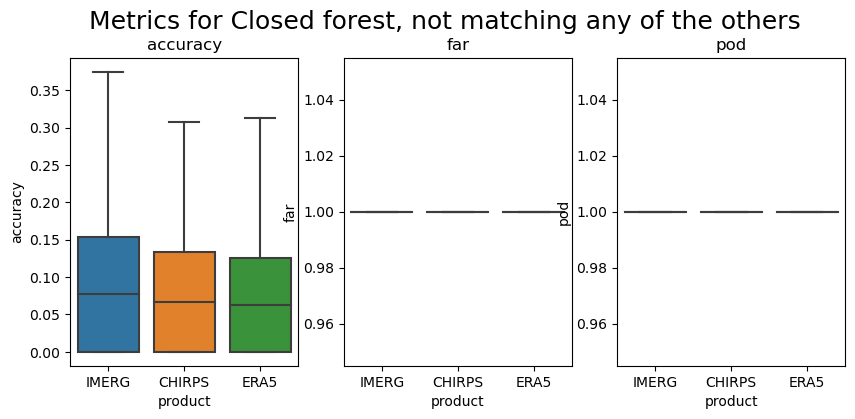

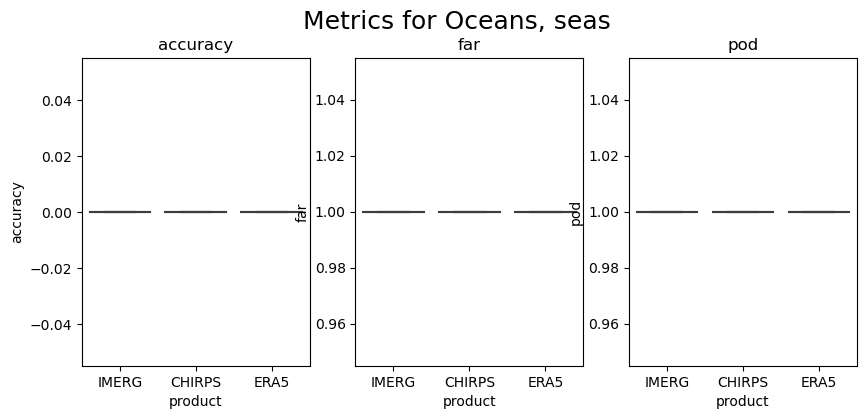

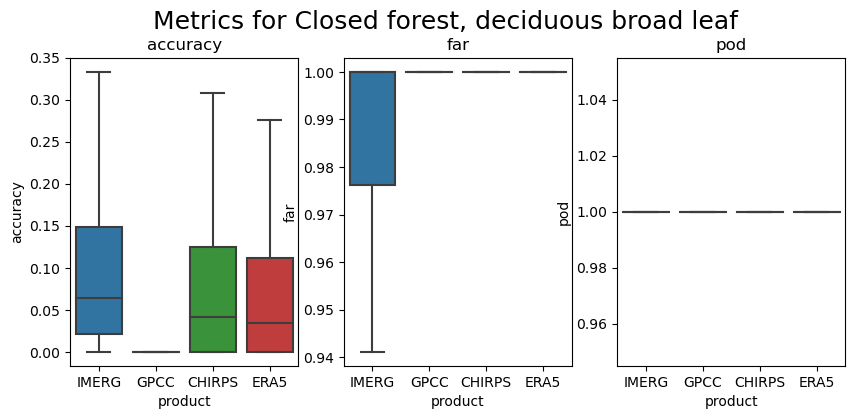

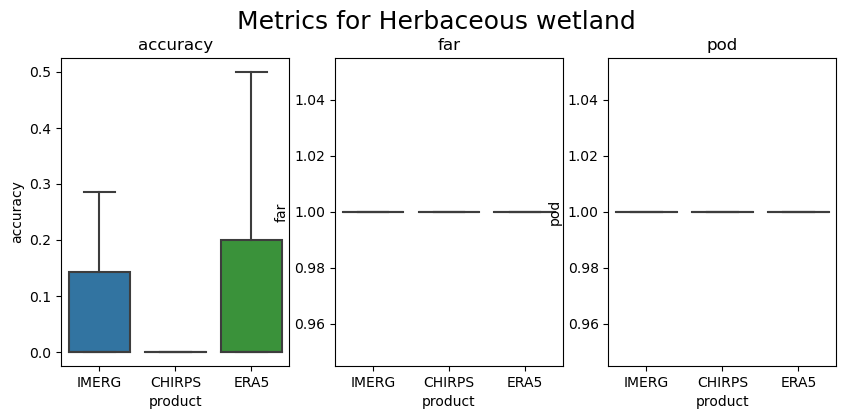

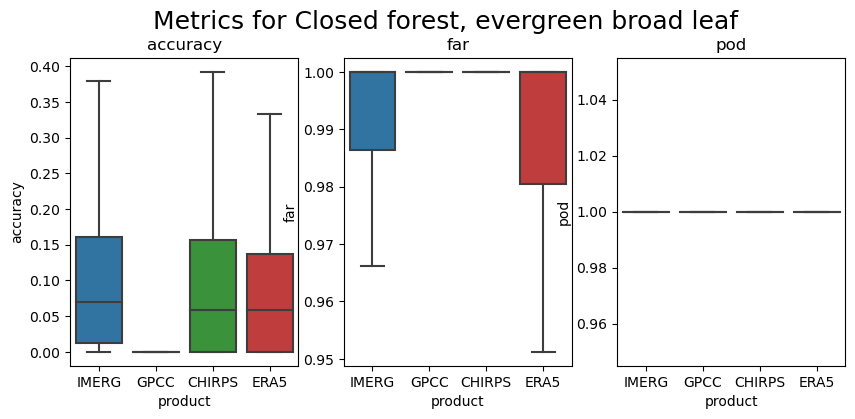

In [139]:
import matplotlib.pyplot as plt

plt.subplots_adjust(wspace=0.8)
plt.subplots_adjust(hspace=0.5)

metrics = ["accuracy","far","pod"]

#countries = ['Kenya','Ethiopia','Somalia']
for i, soil in enumerate(sub_df["description"].unique()):
    #for metric in ['accuracy']:
    fig, axes = plt.subplots(1, 3, figsize=(10,4))
    for metric, ax in zip(metrics, axes.ravel()):
        plt.suptitle(f"Metrics for {soil}", fontsize=18, y=1)
        new_df = sub_df.loc[(sub_df["description"]==soil)].dropna(subset=[metric])
        if len(new_df)>0:
            sns.boxplot(data = new_df, y=metric, x='product', ax=ax, showfliers=False)
        ax.set_title(f"{metric}")
    plt.show()

In [59]:
import xarray as xr
import os

from p_drought_indices.functions.function_clns import load_config
import pandas as pd



def get_dates(gap_year=False):
    if gap_year==False:
        return pd.date_range("01-Jan-2021", "31-Dec-2021", freq="D").to_series().dt.strftime('%d-%b').values
    else:
        return pd.date_range("01-Jan-2020", "31-Dec-2020", freq="D").to_series().dt.strftime('%d-%b').values
    

import calendar
import matplotlib.pyplot as plt
import numpy as np
from typing import Union

def box_plot_year(ds, var:str="ndvi", year:Union[None, int,list]=None, title:str=None, figsize =(15, 7), show_means:bool=False):
    if year==None:
        days = 366
    elif type(year)==list:
        if True in [True for y in year if calendar.isleap(y)]:
            days=366
        else: days = 365
    else:
        days=366 if calendar.isleap(year) else 365

    day_obj = dfDay(ds = ds, var=var)
    df_list = []
    for day in range(1,days+1):
        day_obj.get_day(day)
        locals()[day_obj.df_name] = day_obj.df
        df_list.append(locals()[day_obj.df_name][var])

    bool_days = False if days==365 else True
    list_dates = get_dates(gap_year=bool_days)
 
    fig, ax = plt.subplots(figsize =figsize)
    
    # Creating plot
    if show_means==True:
        boxplot = ax.boxplot(df_list, showfliers=False, patch_artist=True,labels=list_dates, showmeans=True,medianprops=dict(color="green",ls="--",lw=1), meanline=True, meanprops=dict(color="red", ls="-", lw=2))
    else:
        boxplot = ax.boxplot(df_list, showfliers=False, patch_artist=True, labels=list_dates)
    n=7
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='grey', linestyle='dashed')
    if title !=None:
        ax.set_title(title)

    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
    n= 10
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_gridlines()) if i % n != 0]

    ax.tick_params(labelrotation=45)
    for median in boxplot['medians']:
        median.set_color('red')

    for box in boxplot["boxes"]:
        box.set_color("lightblue")

    for whisk in boxplot["whiskers"]:
        whisk.set_color("lightgrey")
    
    # show plot
    plt.show()


CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)
ds = xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], 'smoothed_ndvi.nc'))
vci = xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], 'vci_1D.nc'))

config_directories = [config['SPI']['IMERG']['path'], config['SPI']['GPCC']['path'], config['SPI']['CHIRPS']['path'], config['SPI']['ERA5']['path']]
config_dir_precp = [config['PRECIP']['IMERG']['path'], config['PRECIP']['GPCC']['path'], config['PRECIP']['CHIRPS']['path'], config['PRECIP']['ERA5']['path'],  config['PRECIP']['TAMSTAT']['path']]

class dfDay:
    def __init__(self, ds:xr.Dataset, var:str) -> None:
        ds = ds.assign(dayofyear = ds["time"].dt.dayofyear)
        self.dataset = ds
        self.var = var

  
    def get_day(self, day:int):
        df = self.dataset.where(self.dataset["dayofyear"]==day, drop=True)[self.var].to_dataframe()
        self.df = self._clen_df(df)
        self.df_name = f"data_{day}"
    
    def _clen_df(self, df):
        df.reset_index(drop=False, inplace=True)
        df = df.dropna(subset=[self.var])
        if "spatial_ref" in df.columns:
            df = df.drop(columns={"spatial_ref"})
        return df.reset_index(drop=True)
    
def get_subplot_year(ds, var:str="ndvi", year:Union[None, int,list]=None):
    if year==None:
        days = 366
    elif type(year)==list:
        if True in [True for y in year if calendar.isleap(y)]:
            days=366
        else: days = 365
    else:
        days=366 if calendar.isleap(year) else 365

    day_obj = dfDay(ds = ds, var=var)
    df_list = []
    for day in range(1,days+1):
        day_obj.get_day(day)
        locals()[day_obj.df_name] = day_obj.df
        df_list.append(locals()[day_obj.df_name][var])
    
    bool_days = False if days==365 else True
    list_dates = get_dates(gap_year=bool_days)

    return df_list, list_dates

def crop_get_thresh(ds:xr.DataArray, thresh:int=10):
    null_var = xr.where(ds.notnull(), 1,np.NaN)
    condition_var = xr.where(ds<thresh,1,0)
    return condition_var.where(null_var==1)

def multiple_spi_boxplots(list_late, list_data, list_dates, title, figsize=None, show_means=False):
    fig, axes = plt.subplots(nrows=2,ncols=2, figsize =(15, 7))
    for i, (spi, ax) in enumerate(zip(list_late, axes.ravel())):
        plt.suptitle(title, fontsize=18, y=1)
    
        if show_means==True:
            boxplot = ax.boxplot(list_data[i], showfliers=False, patch_artist=True,labels=list_dates, showmeans=True,medianprops=dict(color="green",ls="--",lw=1), meanline=True, meanprops=dict(color="red", ls="-", lw=2))
        else:
            boxplot = ax.boxplot(list_data[i], showfliers=False, patch_artist=True, labels=list_dates)
        # Creating plot
        #boxplot = ax.boxplot(list_data[i], showfliers=False, patch_artist=True, labels=list_dates)
        n=15
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='grey', linestyle='dashed')
        ax.set_title(f"SPI_GAMMA_{spi}")

        [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
        n= 10
        [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_gridlines()) if i % n != 0]
        ax.tick_params(labelrotation=45)
        for median in boxplot['medians']:
            median.set_color('red')
        for box in boxplot["boxes"]:
            box.set_color("lightblue")
        for whisk in boxplot["whiskers"]:
            whisk.set_color("lightgrey")

        # show plot
    fig.subplots_adjust(hspace=0.5)
    plt.show()

def get_year(year):
    if type(year) == int:
        return year
    else:
        return str(year[0]) + "-" + str(year[-1])

Locator attempting to generate 1830 ticks ([0.6, ..., 366.40000000000003]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1830 ticks ([0.6, ..., 366.40000000000003]), which exceeds Locator.MAXTICKS (1000).


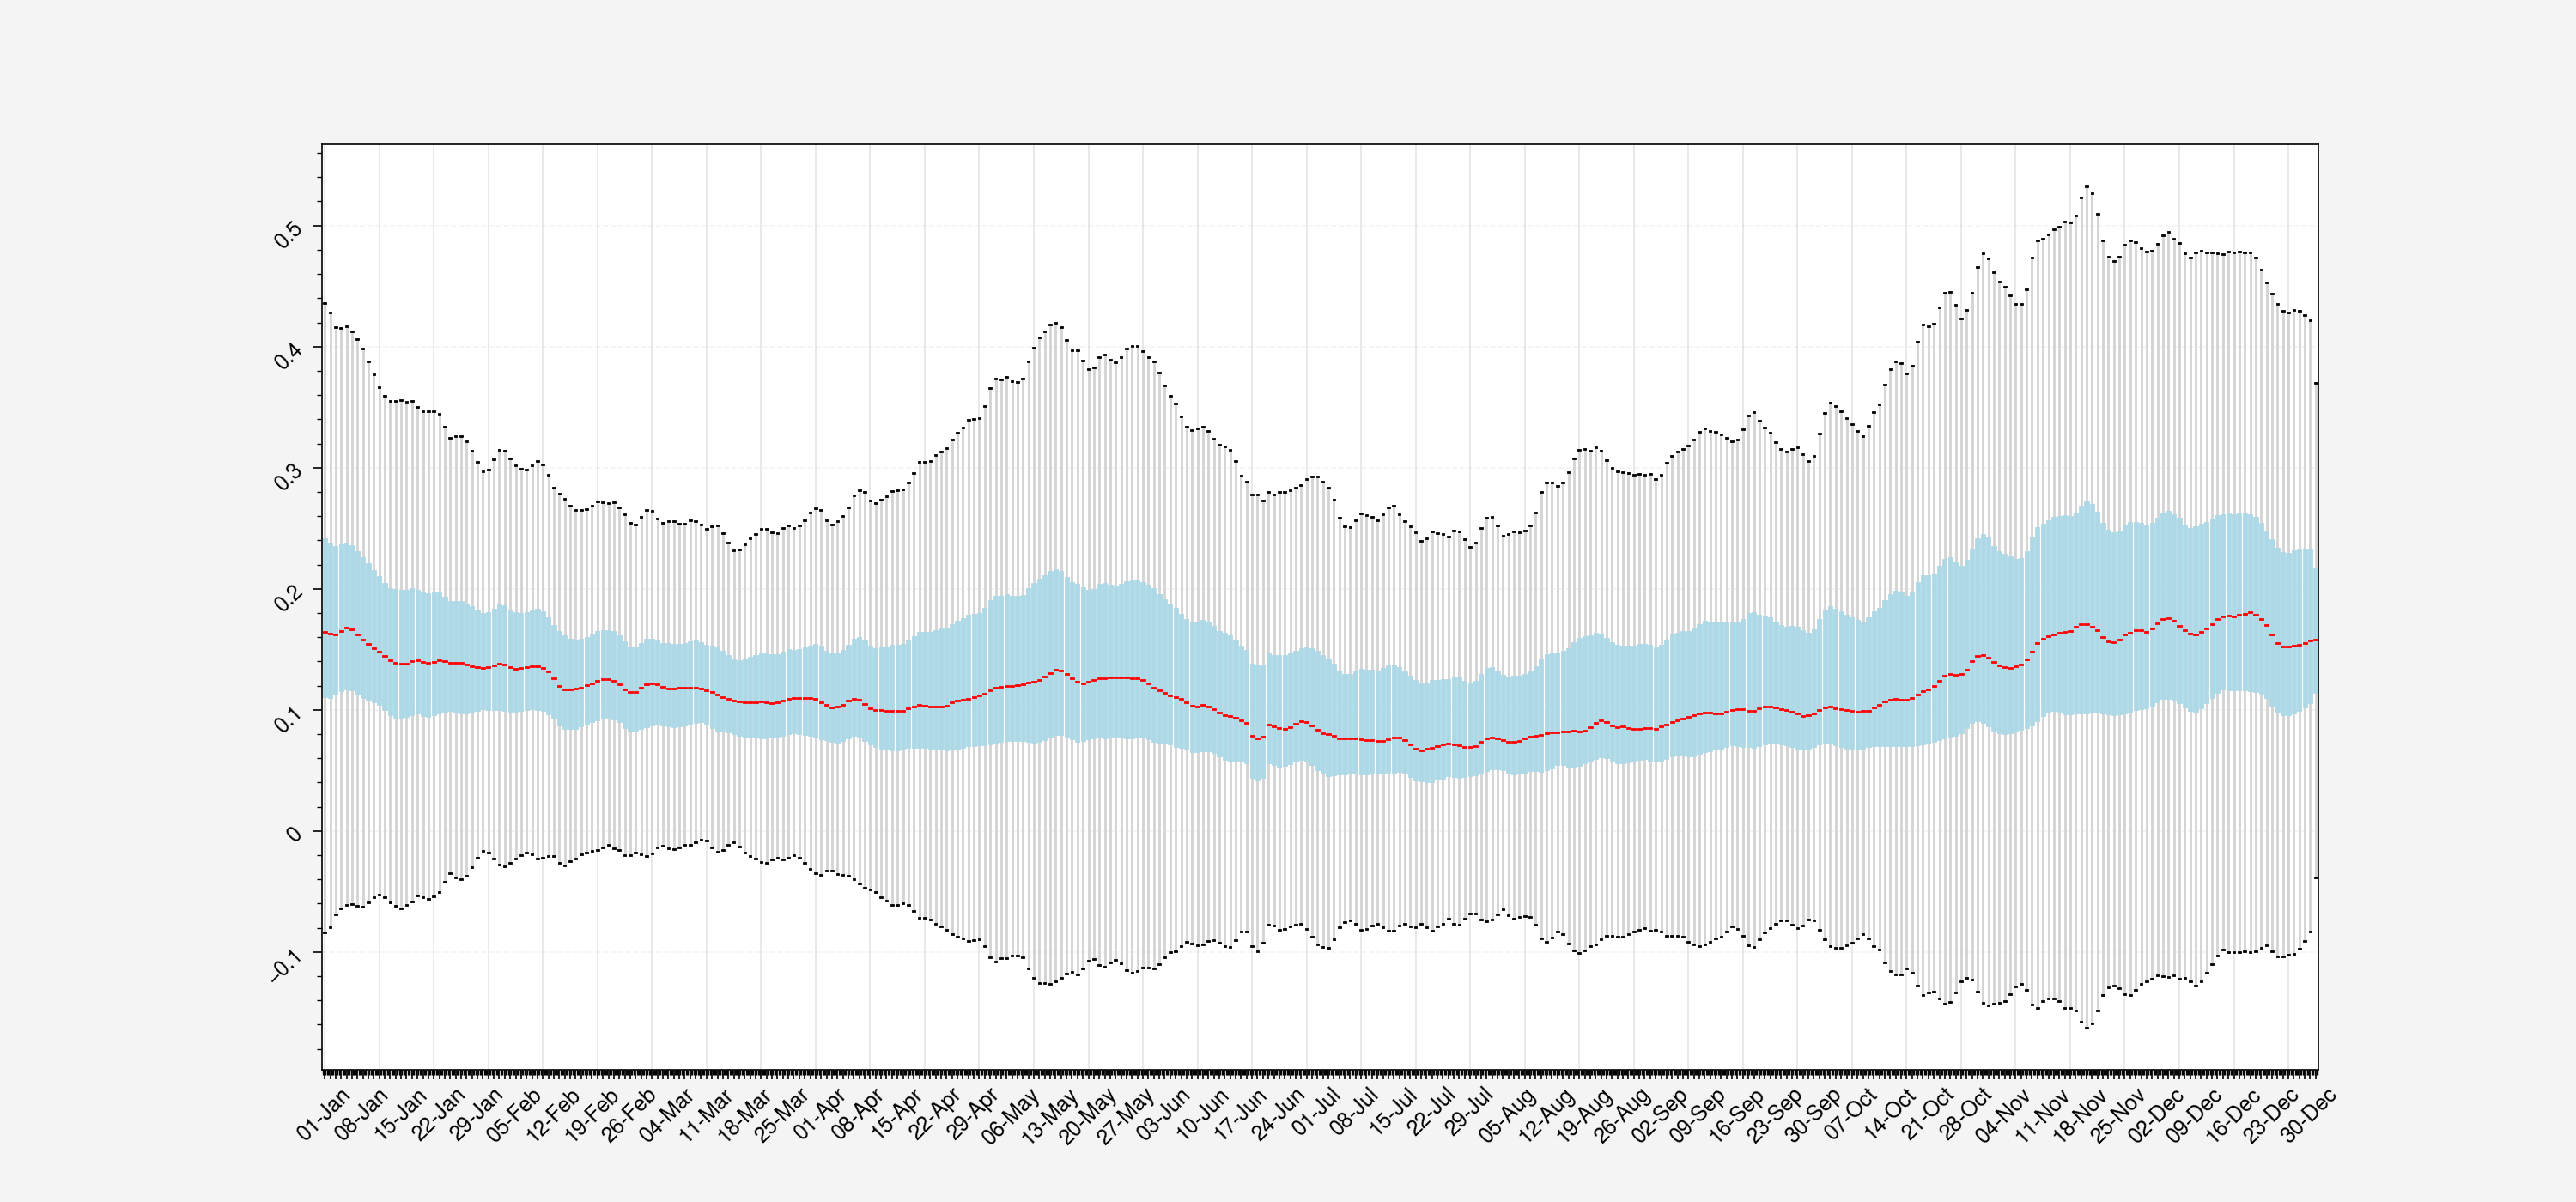

In [18]:
box_plot_year(ds, year=None)

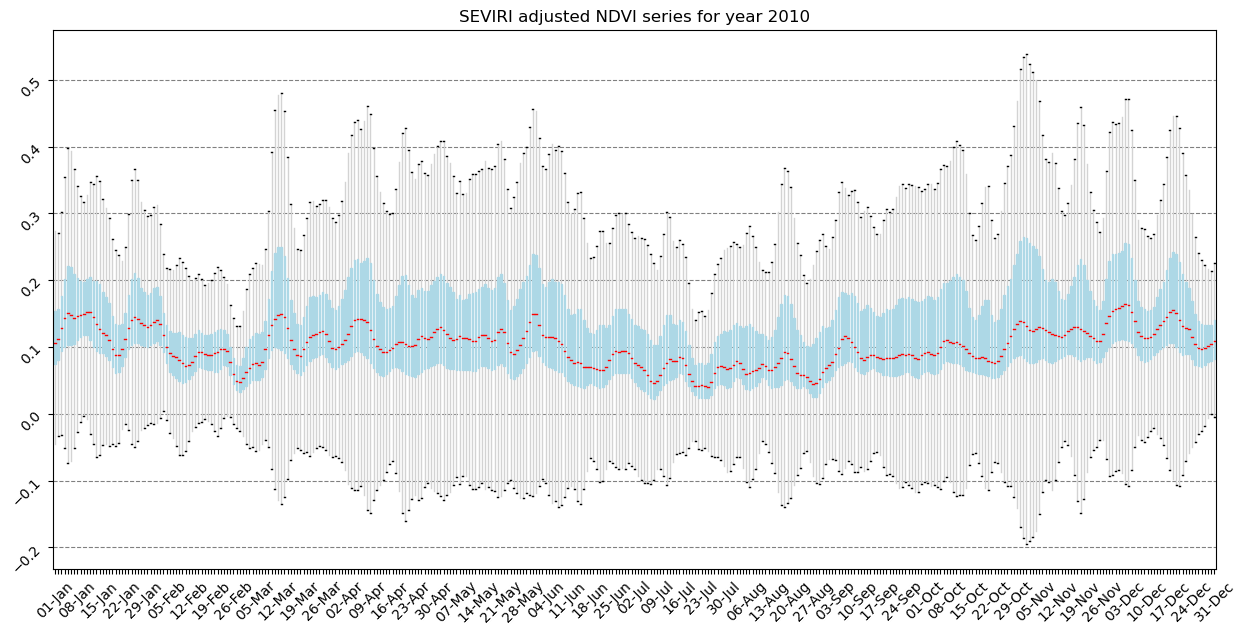

In [122]:
year = 2010
ds_subset = ds.sel(time=ds.time.dt.year.isin([year]))
title = f"SEVIRI adjusted NDVI series for year {year}"
box_plot_year(ds_subset,year=year, title=title)

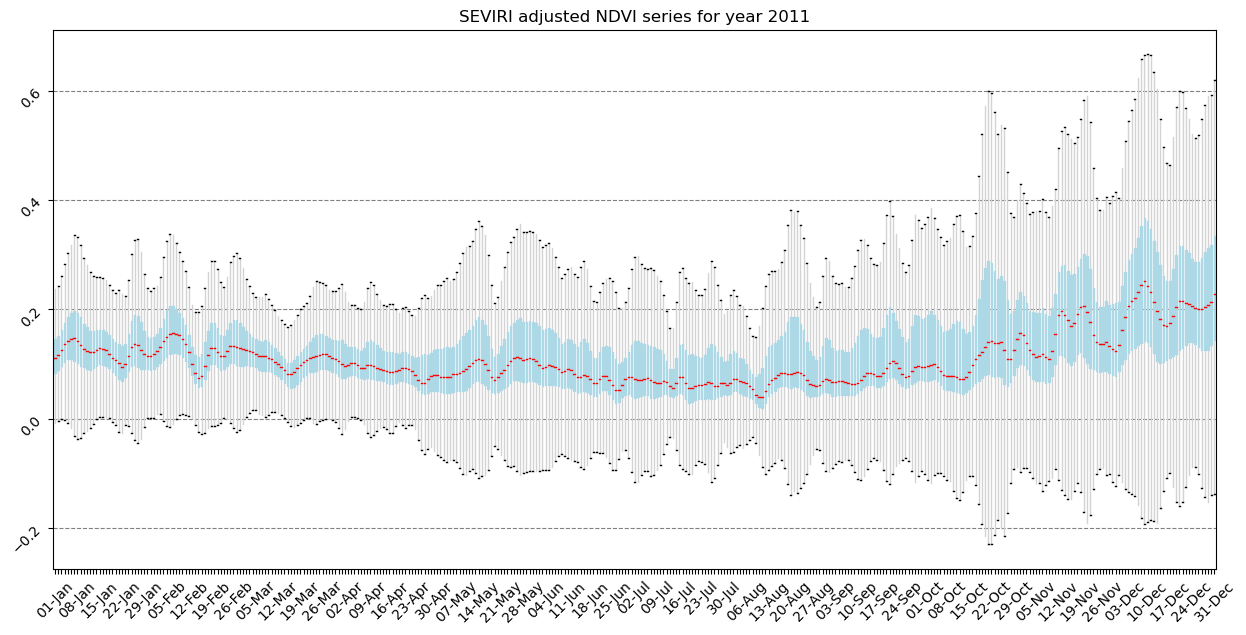

In [124]:
year = 2011
ds_subset = ds.sel(time=ds.time.dt.year.isin([year]))
title = f"SEVIRI adjusted NDVI series for year {year}"
box_plot_year(ds_subset, year=year, title=title)

### Plotting VCI by year

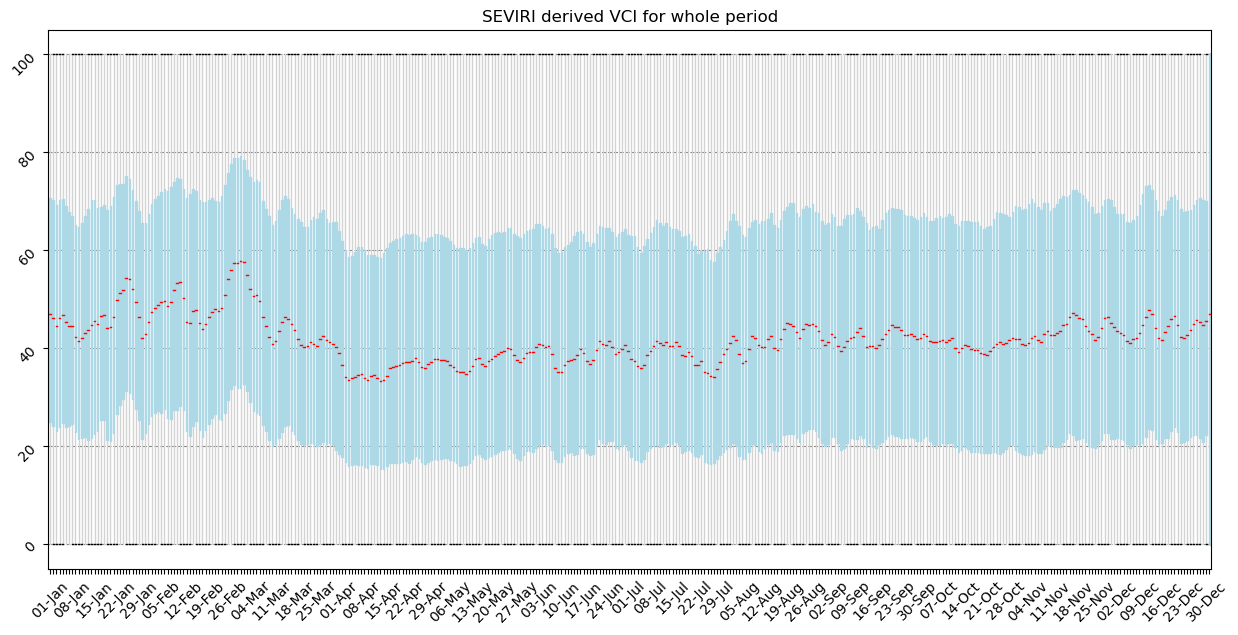

In [126]:
title = f"SEVIRI derived VCI for whole period"
box_plot_year(vci, title = title)

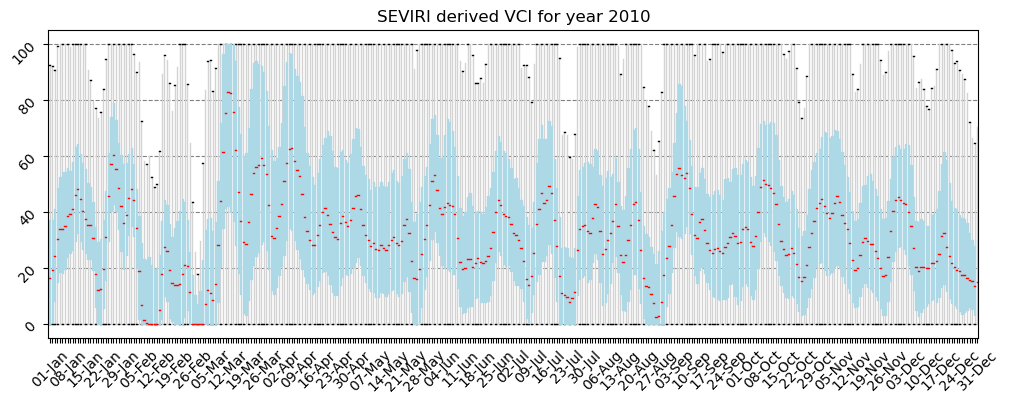

In [130]:
year = 2010
vci_subset = vci.sel(time=ds.time.dt.year.isin([year]))
title = f"SEVIRI derived VCI for year {year}"
box_plot_year(vci_subset, year=year, title=title, figsize=(12,4))

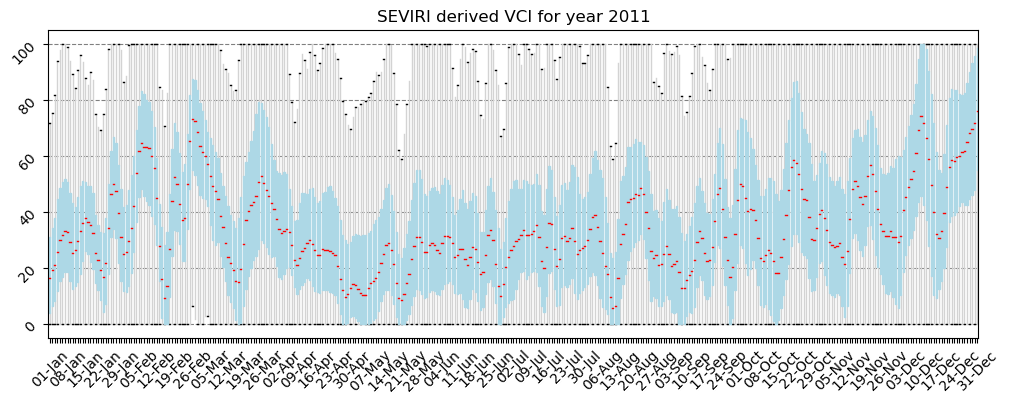

In [131]:
year = 2011
vci_subset = vci.sel(time=ds.time.dt.year.isin([year]))
title = f"SEVIRI derived VCI for year {year}"
box_plot_year(vci_subset, year=year, title=title, figsize=(12,4))

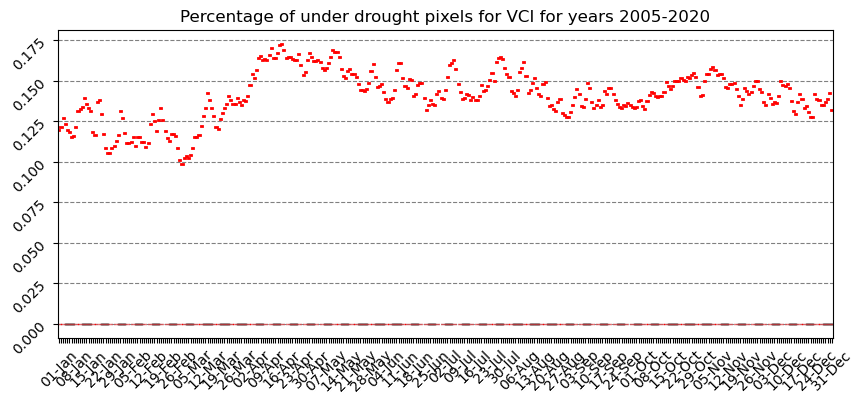

In [62]:
res_ds = crop_get_thresh(vci["ndvi"]).to_dataset()
title="Percentage of under drought pixels for VCI for years 2005-2020"
box_plot_year(res_ds, title = title, year=year, show_means=True, figsize=(10,4))

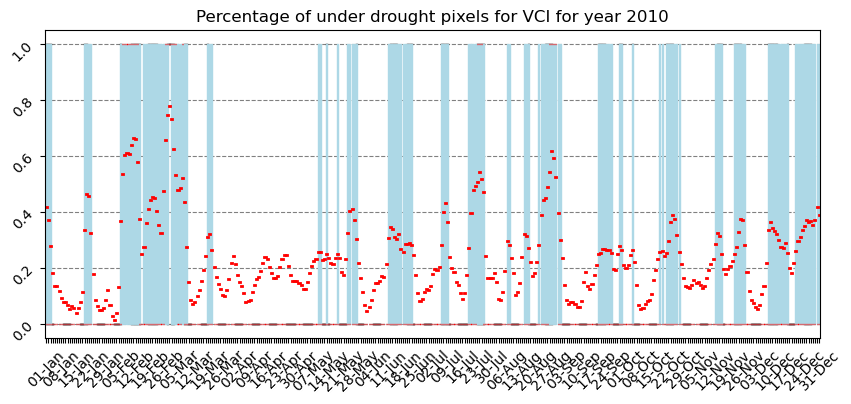

In [60]:
year =2010
subset_res = res_ds.sel(time=res_ds.time.dt.year.isin([year]))
title=f"Percentage of under drought pixels for VCI for year {year}"
box_plot_year(subset_res, title = title, year=year, show_means=True, figsize=(10,4))

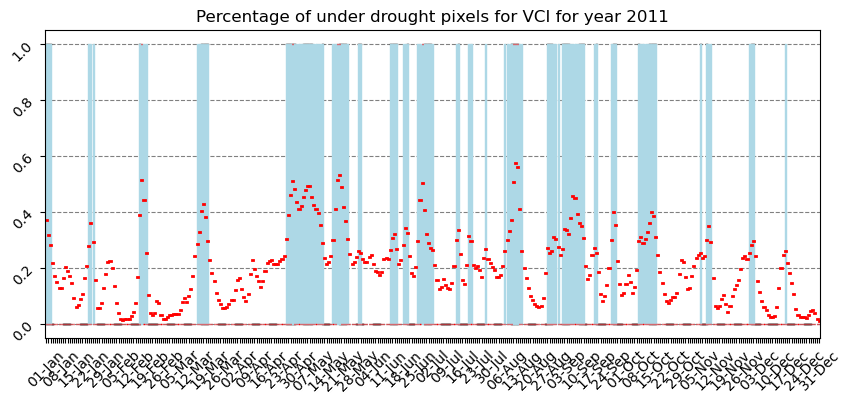

In [61]:
year =2011
subset_res = res_ds.sel(time=res_ds.time.dt.year.isin([year]))
title=f"Percentage of under drought pixels for VCI for year {year}"
box_plot_year(subset_res, title = title, year=year, show_means=True, figsize=(10,4))

### Visualize SPI by product 

In [ ]:
list_late = [30, 60, 90, 180]

for product_dir in [config['SPI']['GPCC']['path'], config['SPI']['ERA5']['path'], config['SPI']['CHIRPS']['path'], config['SPI']['IMERG']['path']]:
    print("New product plotting...")
    fig, axes = plt.subplots(nrows=2,ncols=2, figsize =(15, 7))
    list_data = []
    for late in list_late:
        var_target = f"spi_gamma_{late}"
        files = [f for f in os.listdir(product_dir) if var_target in f ]
        locals()[f"spi_{late}"] = xr.open_dataset(os.path.join(product_dir, files[0]))
        locals()[f"df_list_{late}"], list_dates = get_subplot_year(locals()[f"spi_{late}"] , var=var_target, year=np.arange(2005, 2021).tolist())
        list_data.append(locals()[f"df_list_{late}"],)
    
    product = files[0].split("_")[0]
    title = f"SPI for product {product}"
    multiple_spi_boxplots(list_late, list_data, title=title, list_dates)

### Plotting precipitation series

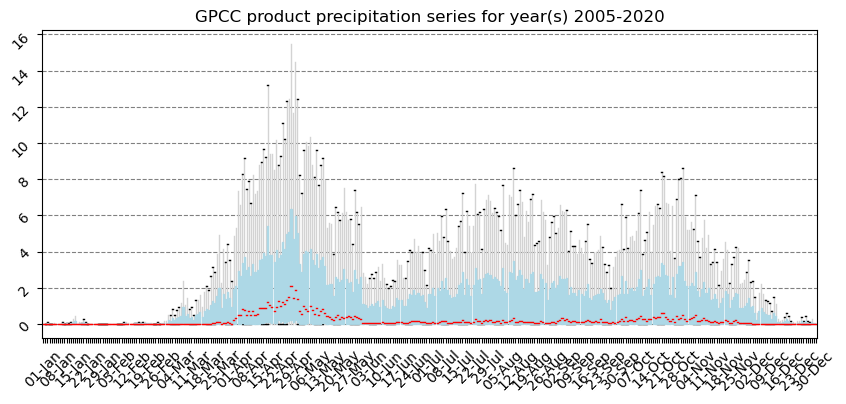

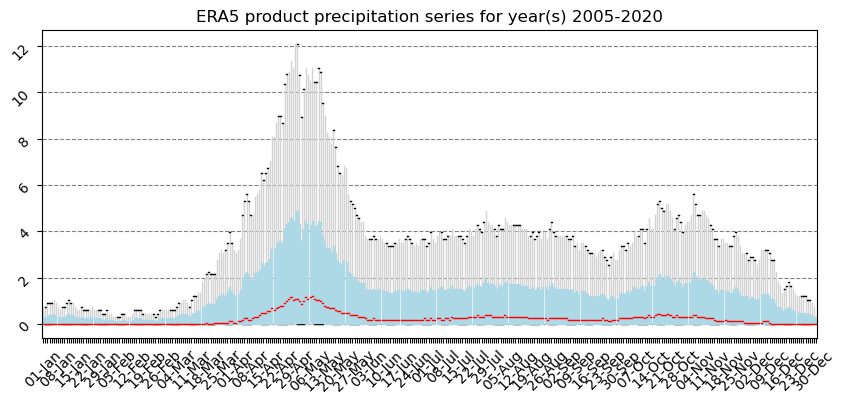

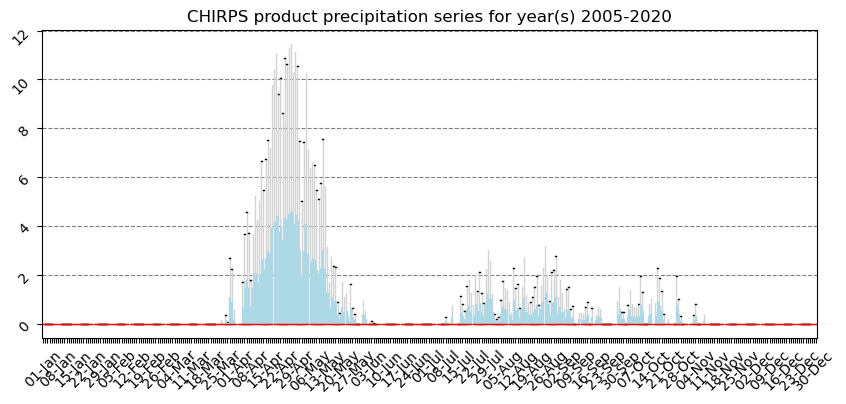

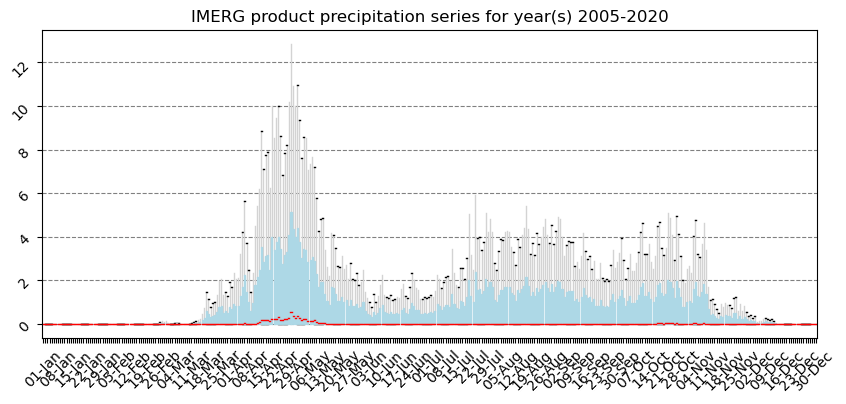

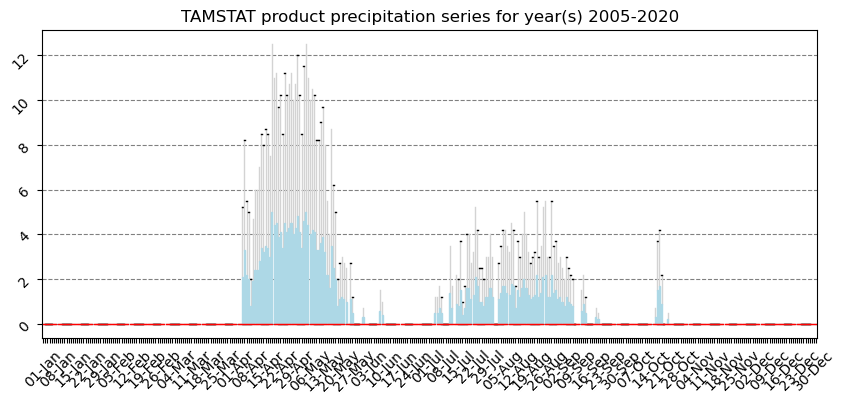

In [114]:
year = np.arange(2005, 2021).tolist()

for product_dir in config_directories:
    list_files = [f for f in os.listdir(product_dir) if (f.endswith(".nc")) and ("merged" in f)]
    ds = xr.open_dataset(os.path.join(product_dir, list_files[0]))
    variable = [var for var in ds.data_vars if var!= "spatial_ref"][0]
    name = list_files[0].split("_")[0]
    box_plot_year(ds, var=variable, year=year, title=f"{name.upper()} product precipitation series for year(s) {get_year(year)}", figsize=(10,4))

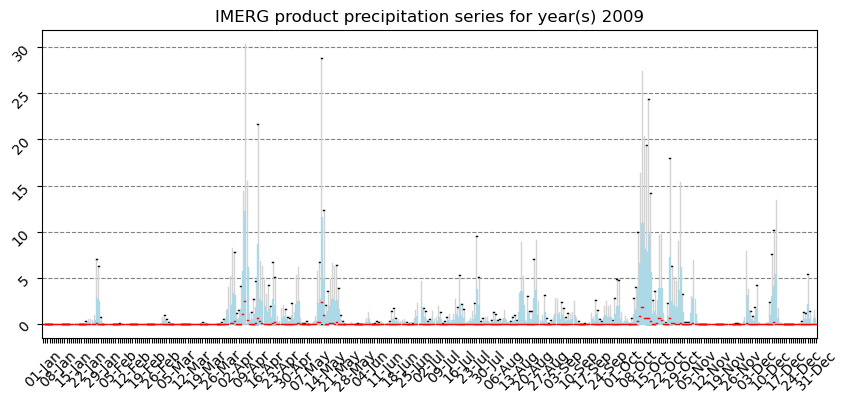

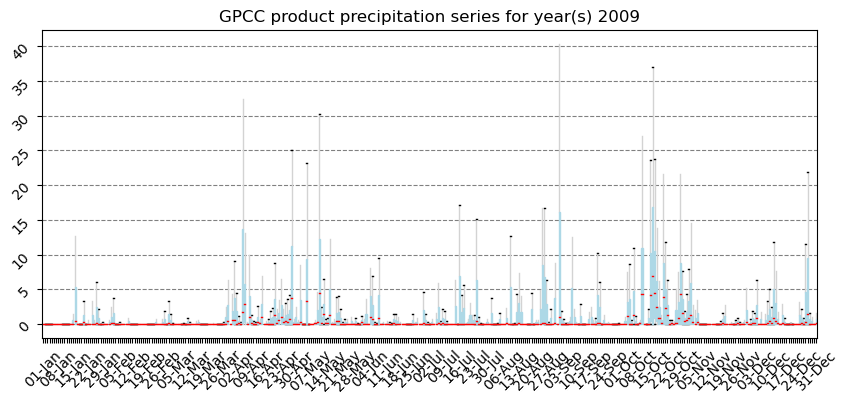

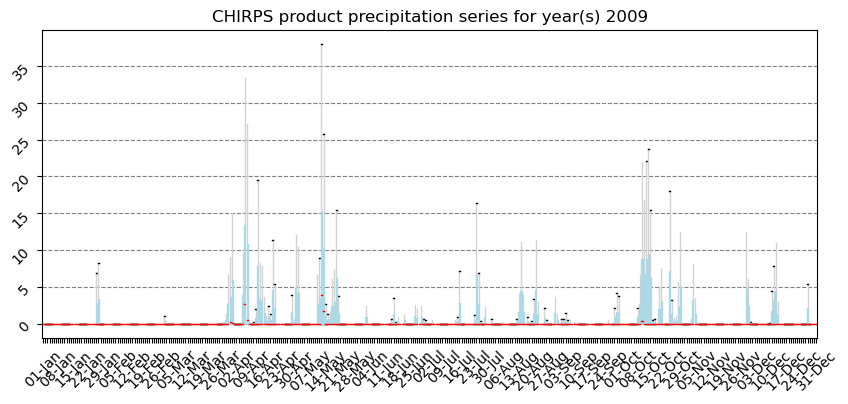

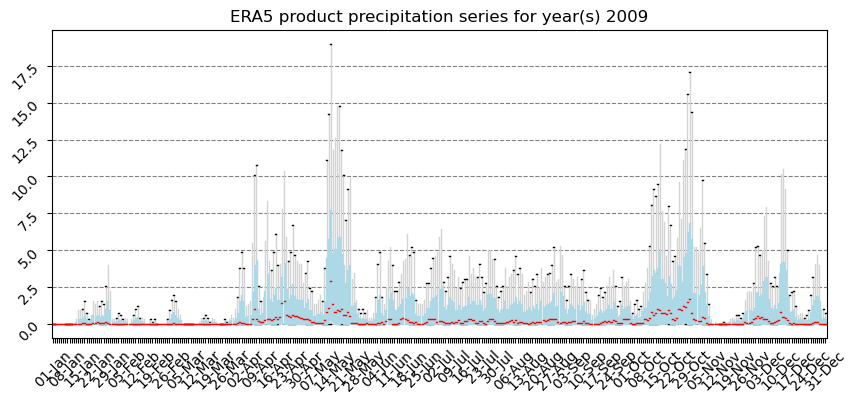

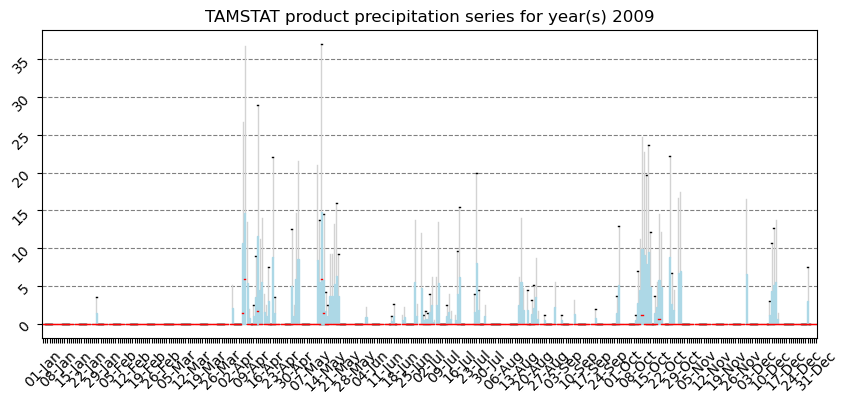

In [132]:
year = 2009
for product_dir in config_dir_precp:
    list_files = [f for f in os.listdir(product_dir) if (f.endswith(".nc")) and ("merged" in f)]
    ds = xr.open_dataset(os.path.join(product_dir, list_files[0]))
    subset_ds=ds.sel(time=ds.time.dt.year.isin(year))
    variable = [var for var in ds.data_vars if var!= "spatial_ref"][0]
    name = list_files[0].split("_")[0]
    box_plot_year(subset_ds, var=variable, year=year, title=f"{name.upper()} product precipitation series for year(s) {get_year(year)}", figsize=(10,4))

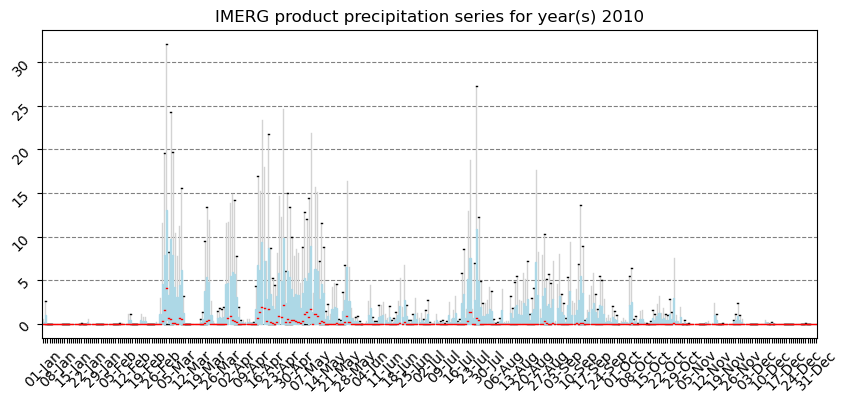

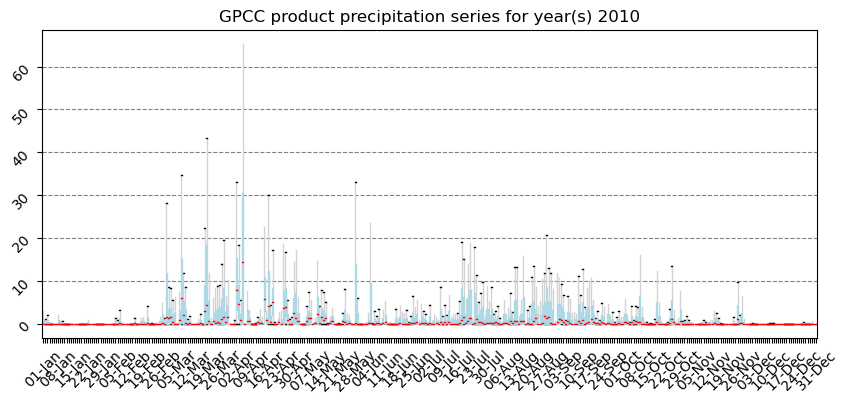

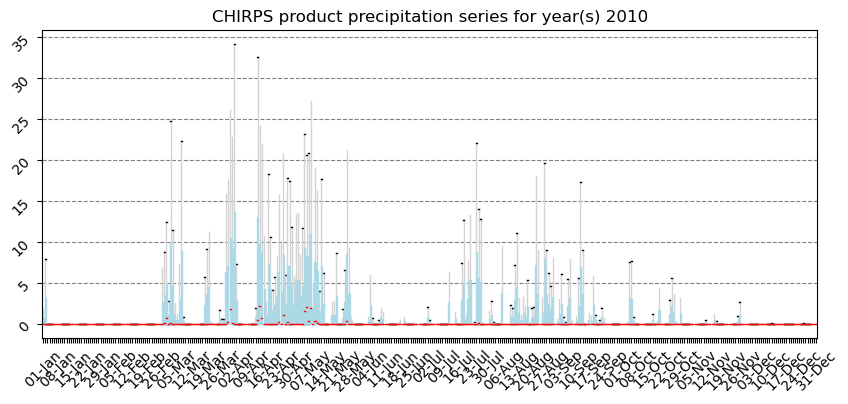

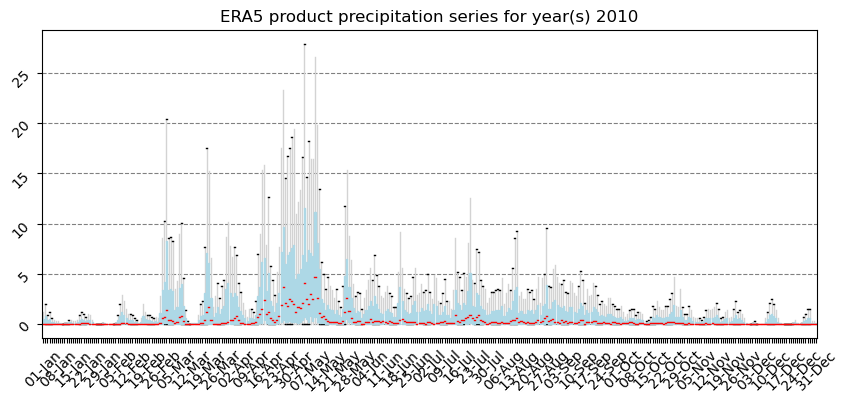

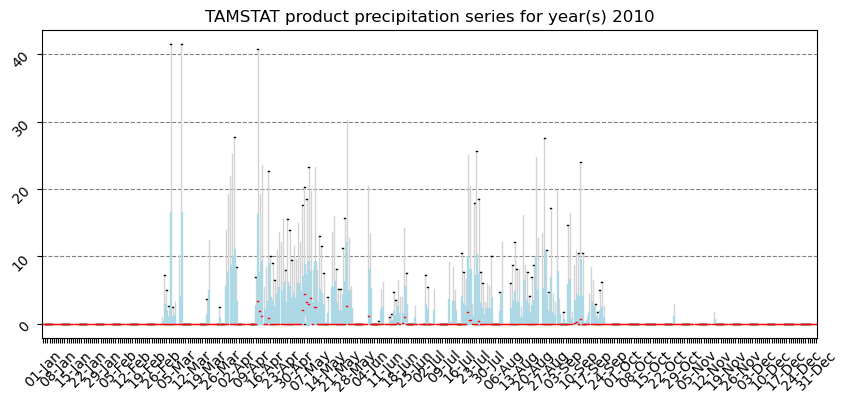

In [133]:
year = 2010
for product_dir in config_dir_precp:
    list_files = [f for f in os.listdir(product_dir) if (f.endswith(".nc")) and ("merged" in f)]
    ds = xr.open_dataset(os.path.join(product_dir, list_files[0]))
    subset_ds=ds.sel(time=ds.time.dt.year.isin(year))
    variable = [var for var in ds.data_vars if var!= "spatial_ref"][0]
    name = list_files[0].split("_")[0]
    box_plot_year(subset_ds, var=variable, year=year, title=f"{name.upper()} product precipitation series for year(s) {get_year(year)}", figsize=(10,4))

In [90]:
def crop_get_spi(ds:xr.DataArray, thresh:int=-2):
    null_var = xr.where(ds.notnull(), 1,np.NaN)
    condition_var = xr.where(ds<=thresh,1,0)
    return condition_var.where(null_var==1)

year = 2010

def plot_products_drought_pixels(year:Union[list, int], list_late:list = [30, 60, 90, 180], prod_directories=config_directories):
    for product_dir in prod_directories:
        print("Plotting new product...")
        list_data = []
        for latency in list_late:
            var_target = f"spi_gamma_{late}"
            files = [f for f in os.listdir(product_dir) if var_target in f ]
            spi_temp = xr.open_dataset(os.path.join(product_dir, files[0]))
            subset_ds=spi_temp.sel(time=spi_temp.time.dt.year.isin(year))
            locals()[f"spi_{late}"] = crop_get_spi(subset_ds)
            locals()[f"df_list_{late}"],list_dates = get_subplot_year(locals()[f"spi_{late}"] , var=var_target, year=year)
            list_data.append(locals()[f"df_list_{late}"],)
            spi_temp.close()

        product = files[0].split("_")[0]
        title = f"Percentage of drought pixels for product {product} in year {get_year(year)}"
        multiple_spi_boxplots(list_late, list_data, title=title, list_dates = list_dates, show_means=True)
            

Plotting new product...


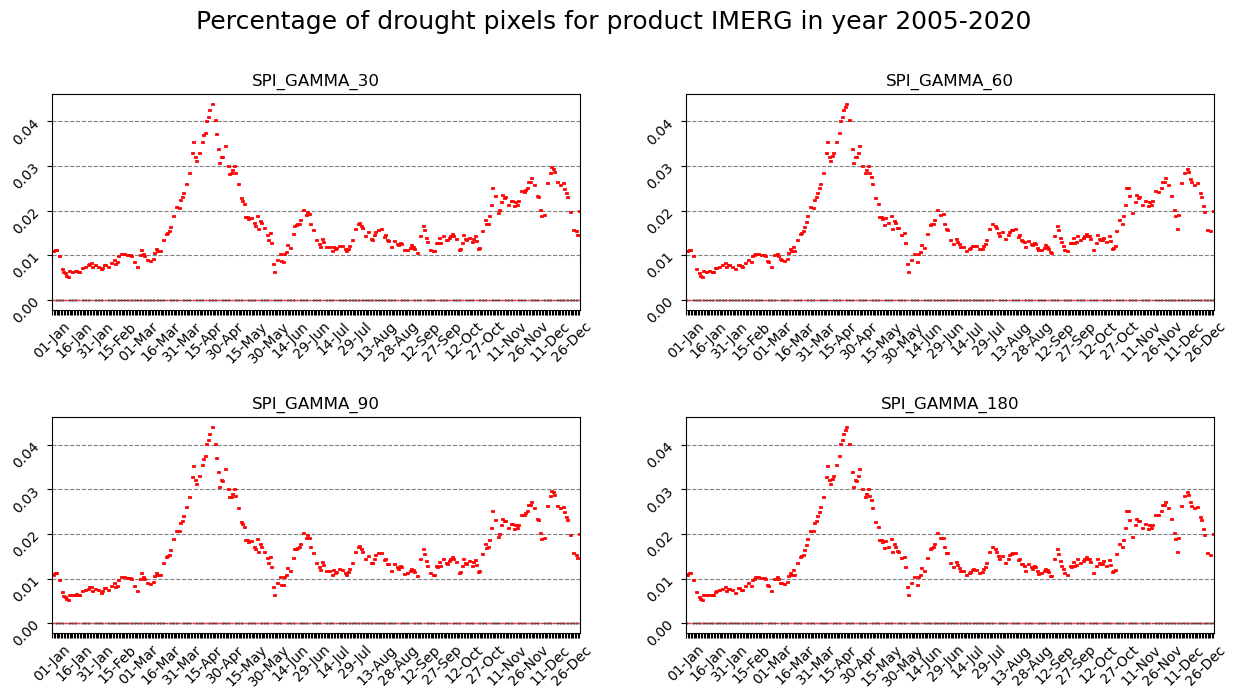

Plotting new product...


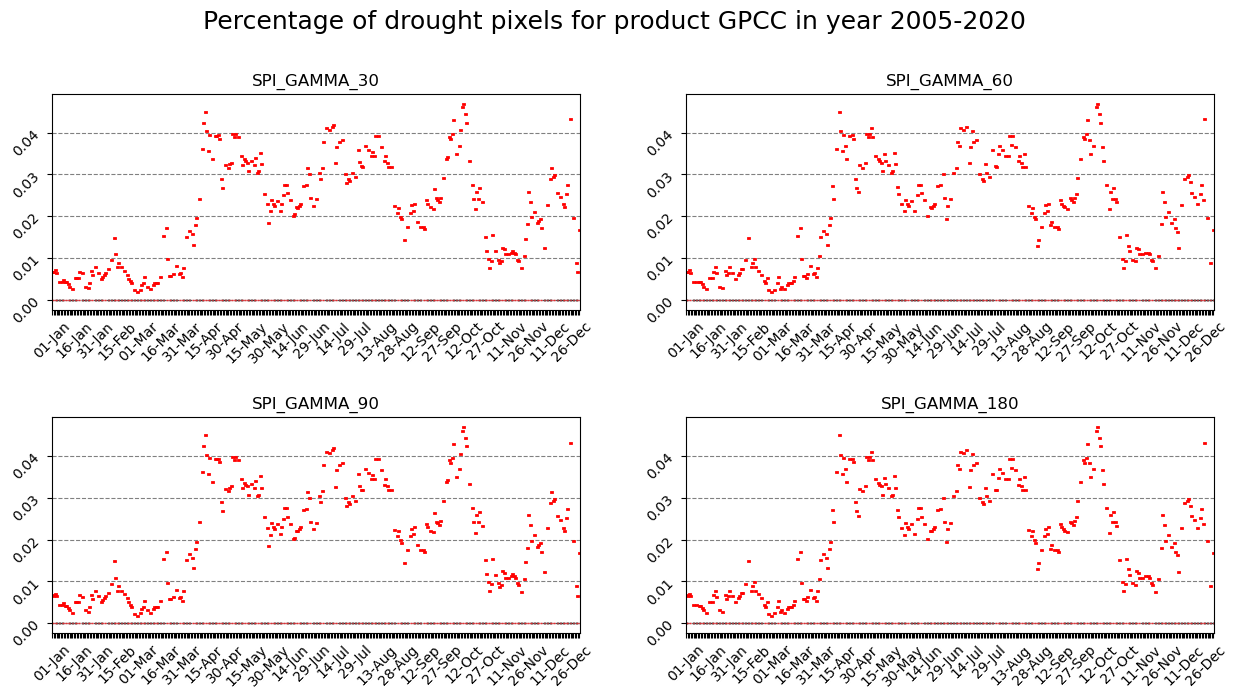

Plotting new product...


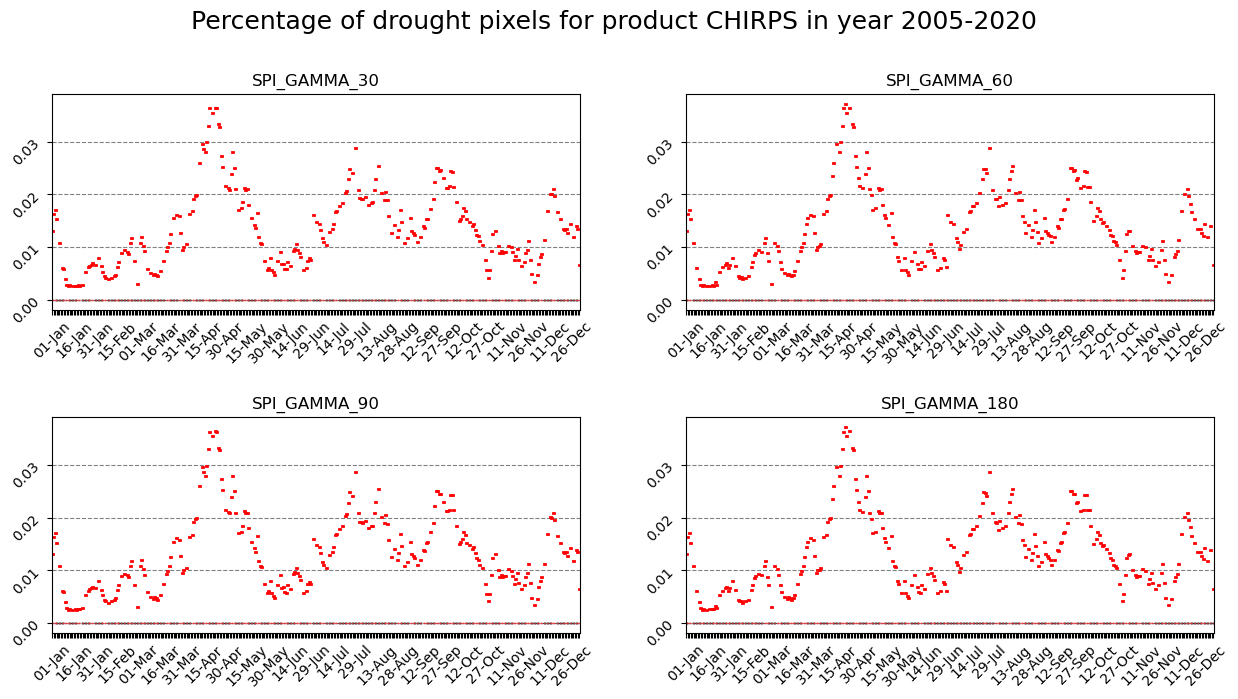

Plotting new product...


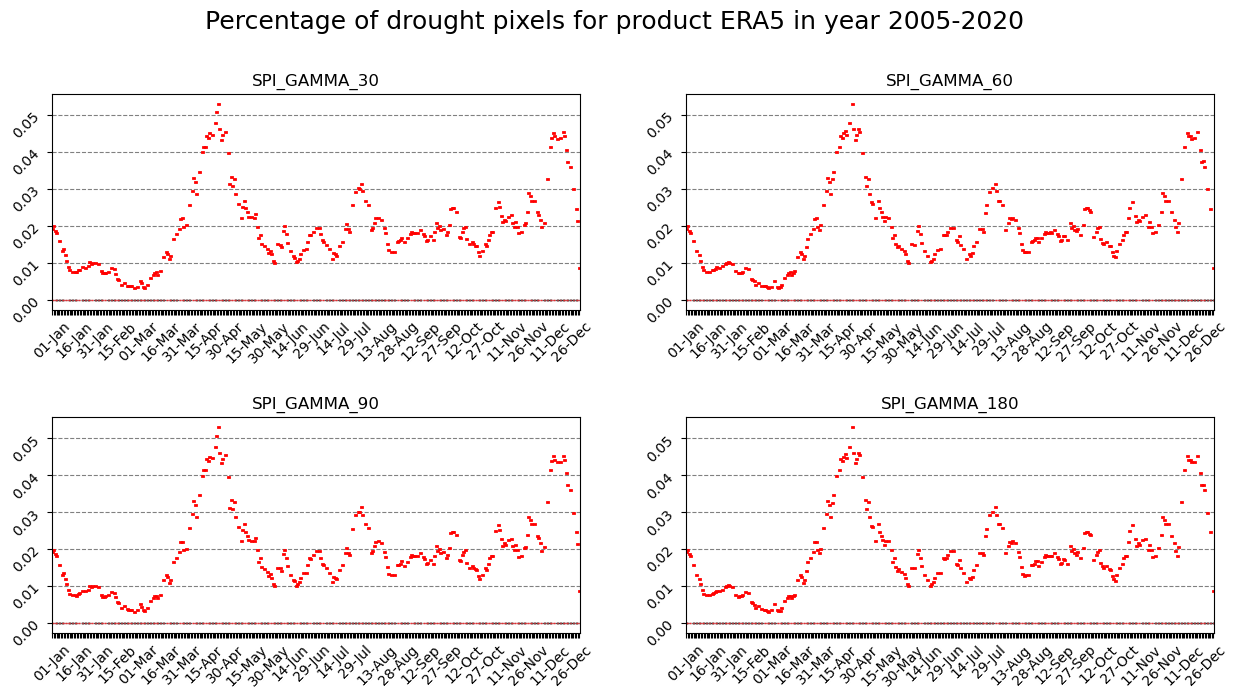

In [91]:
year = np.arange(2005, 2021).tolist()
plot_products_drought_pixels(year)

Plotting new product...


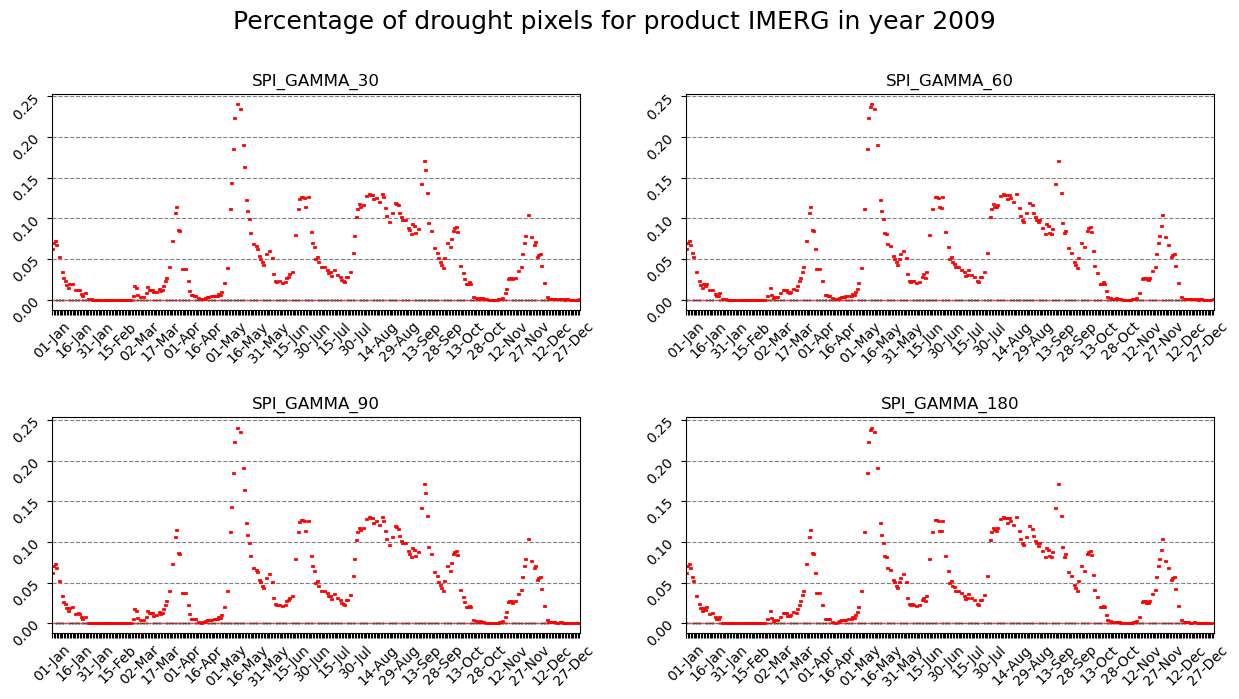

Plotting new product...


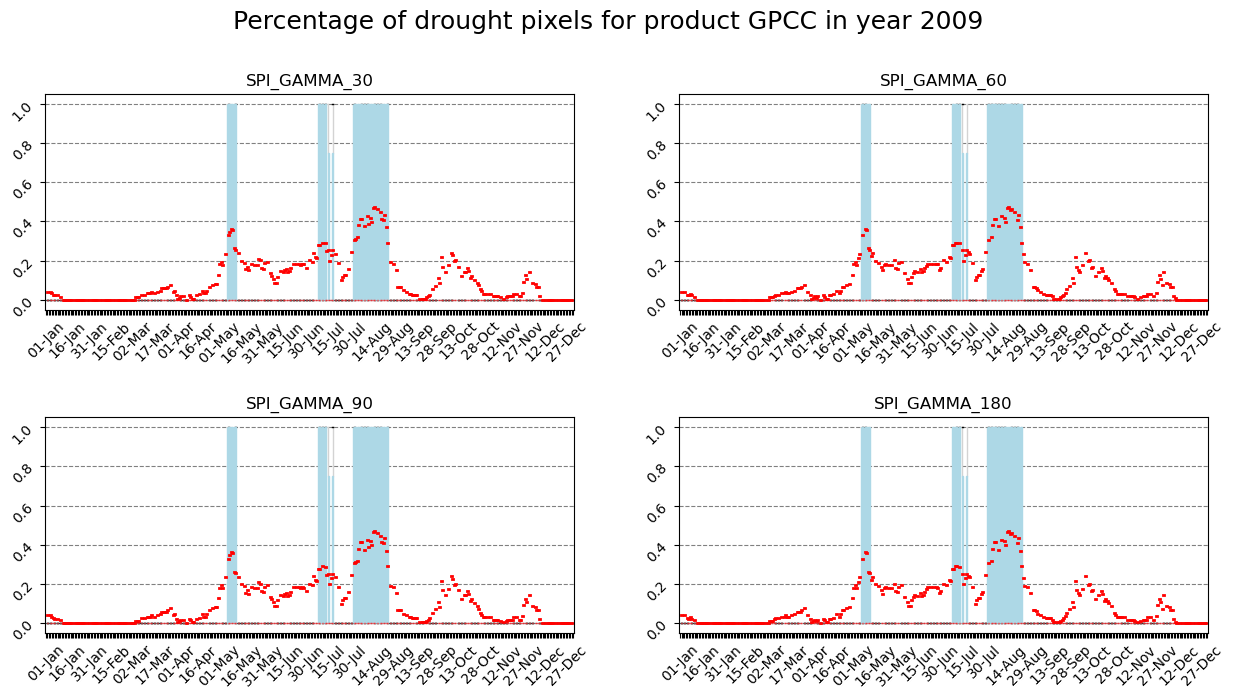

Plotting new product...


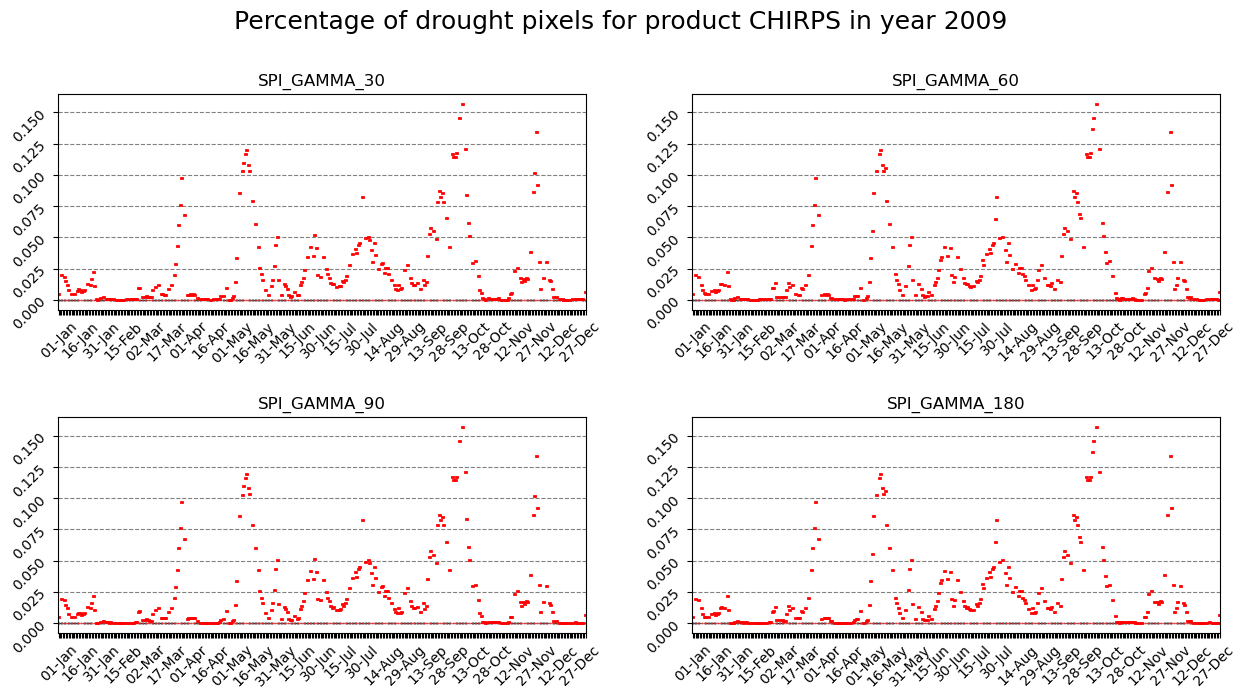

Plotting new product...


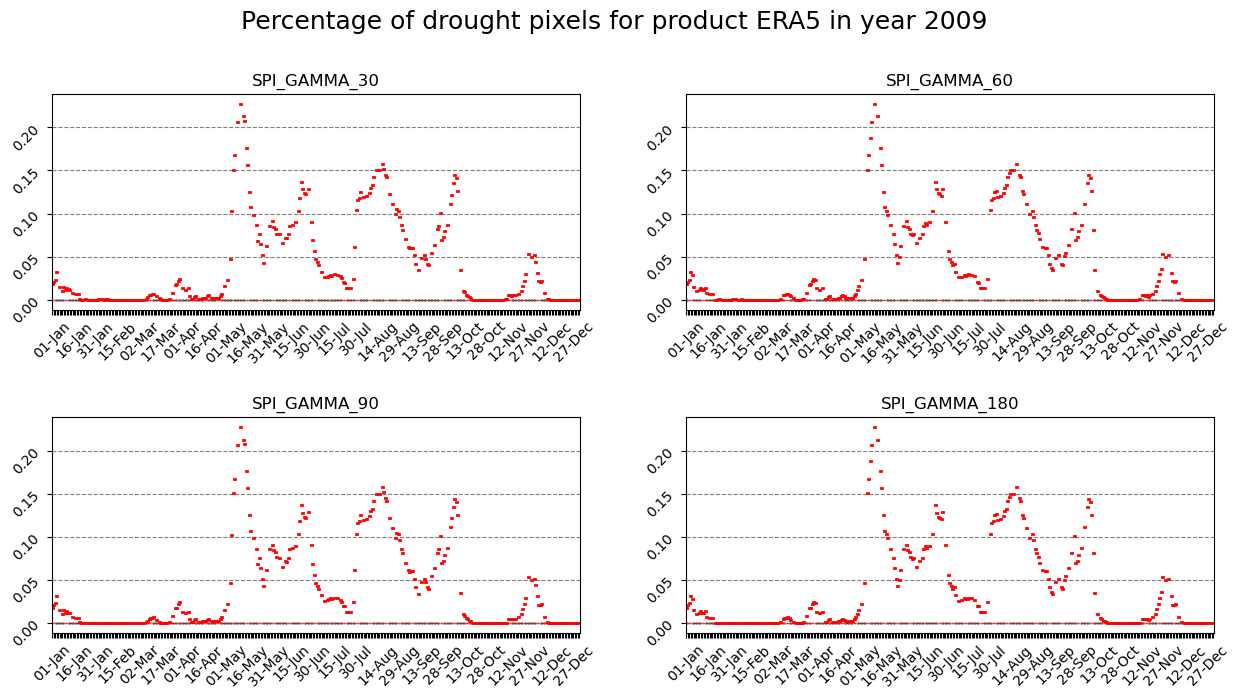

Plotting new product...


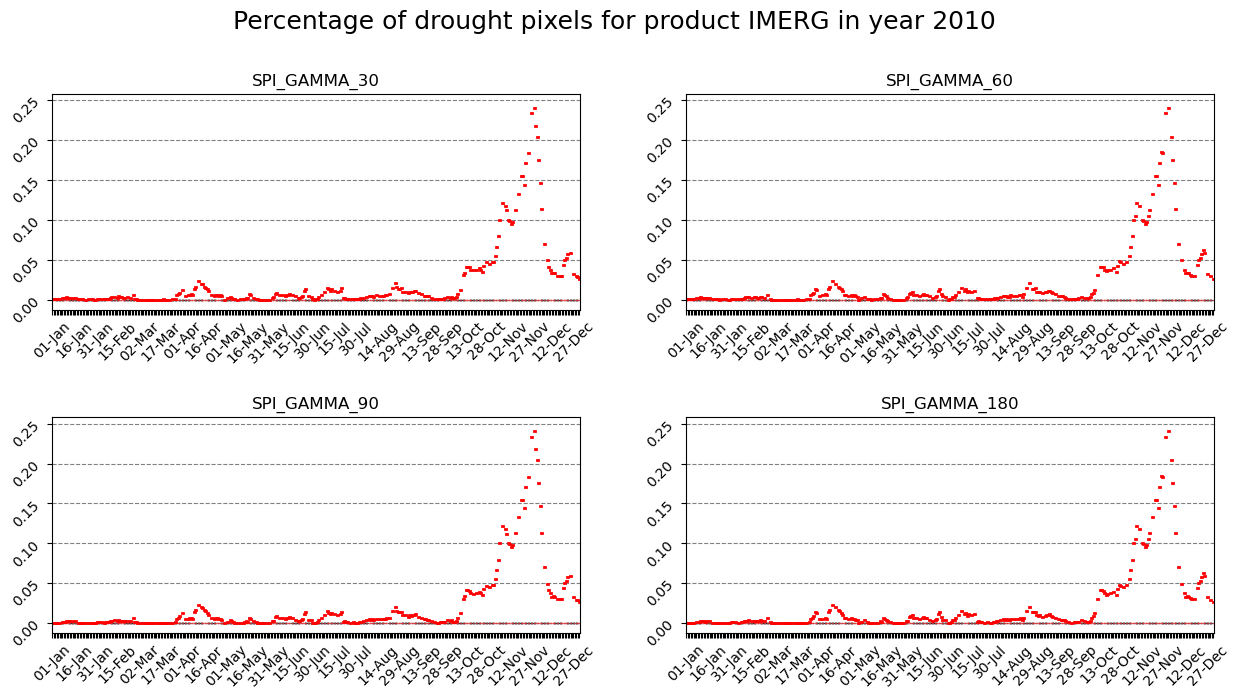

Plotting new product...


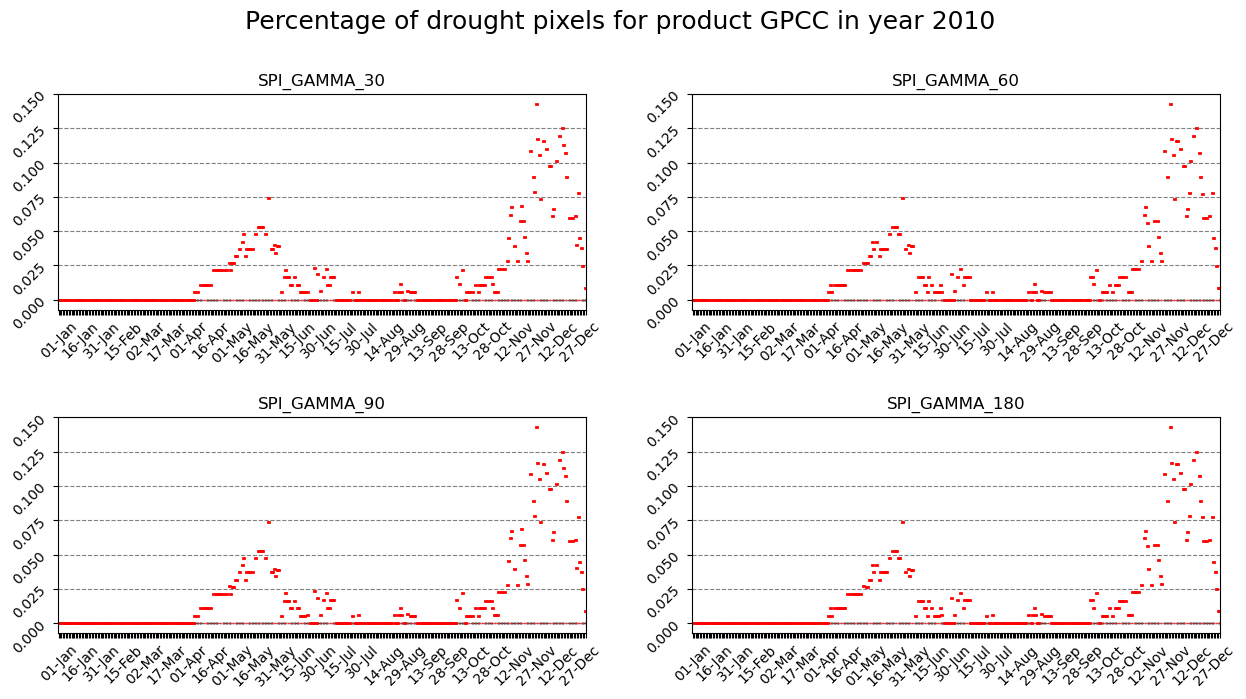

Plotting new product...


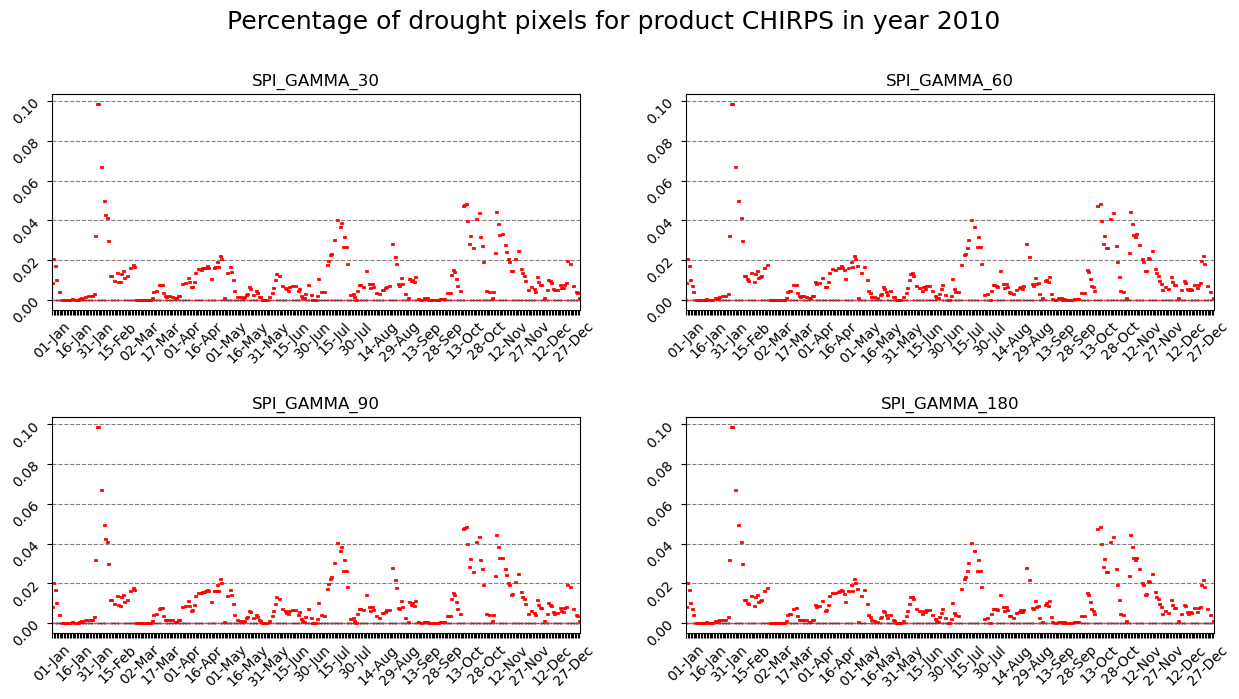

Plotting new product...


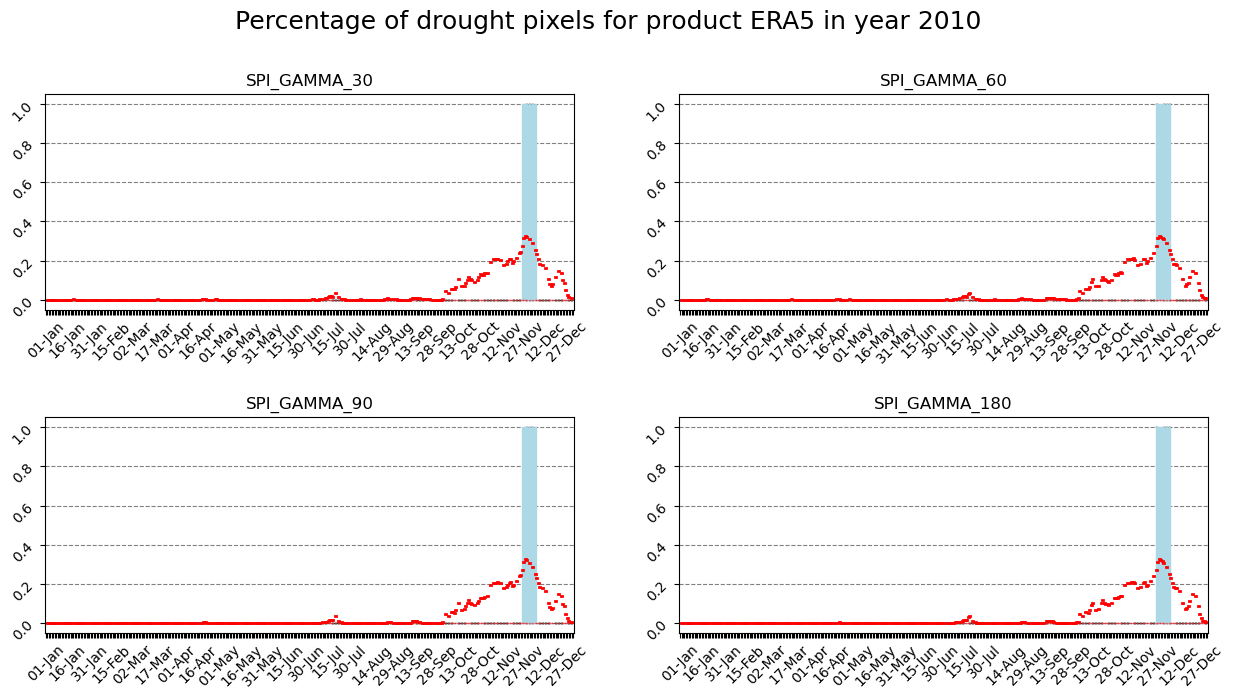

Plotting new product...


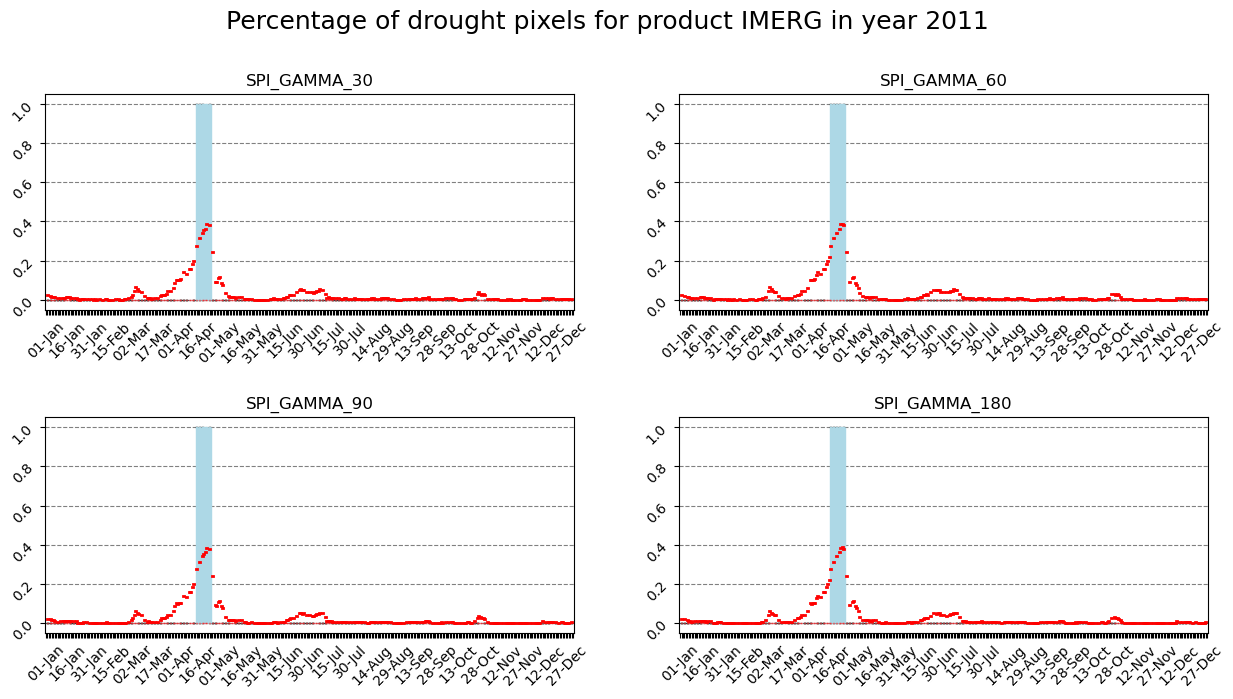

Plotting new product...


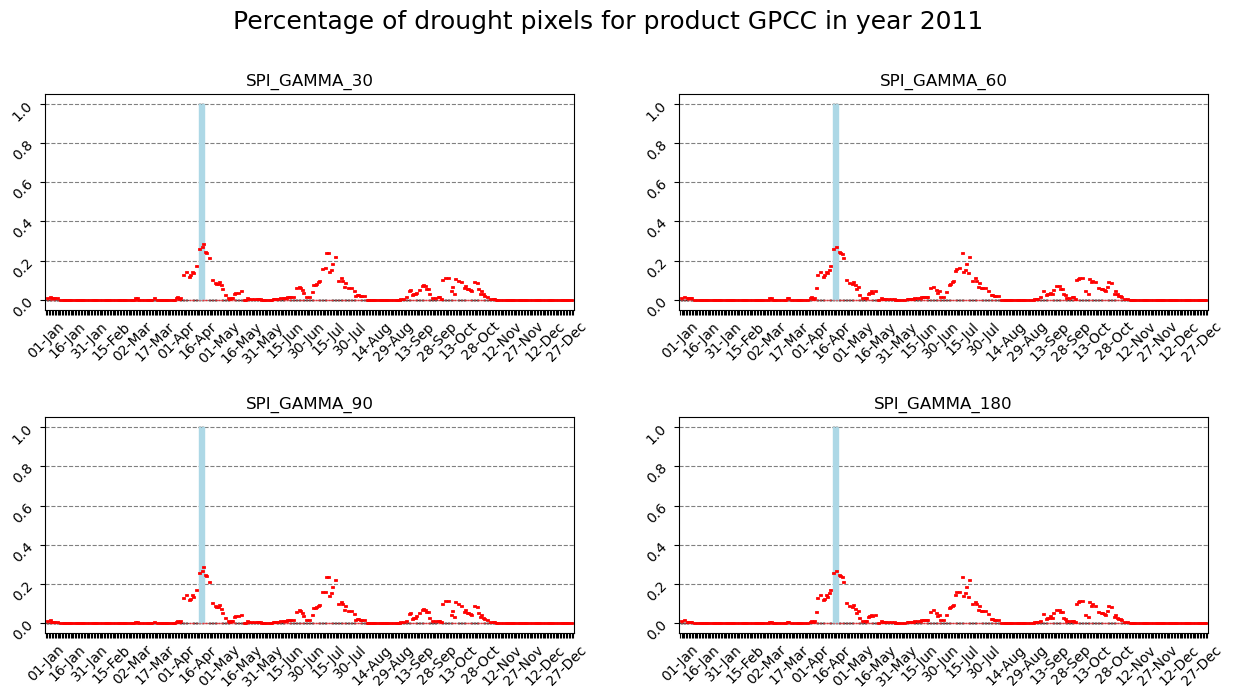

Plotting new product...


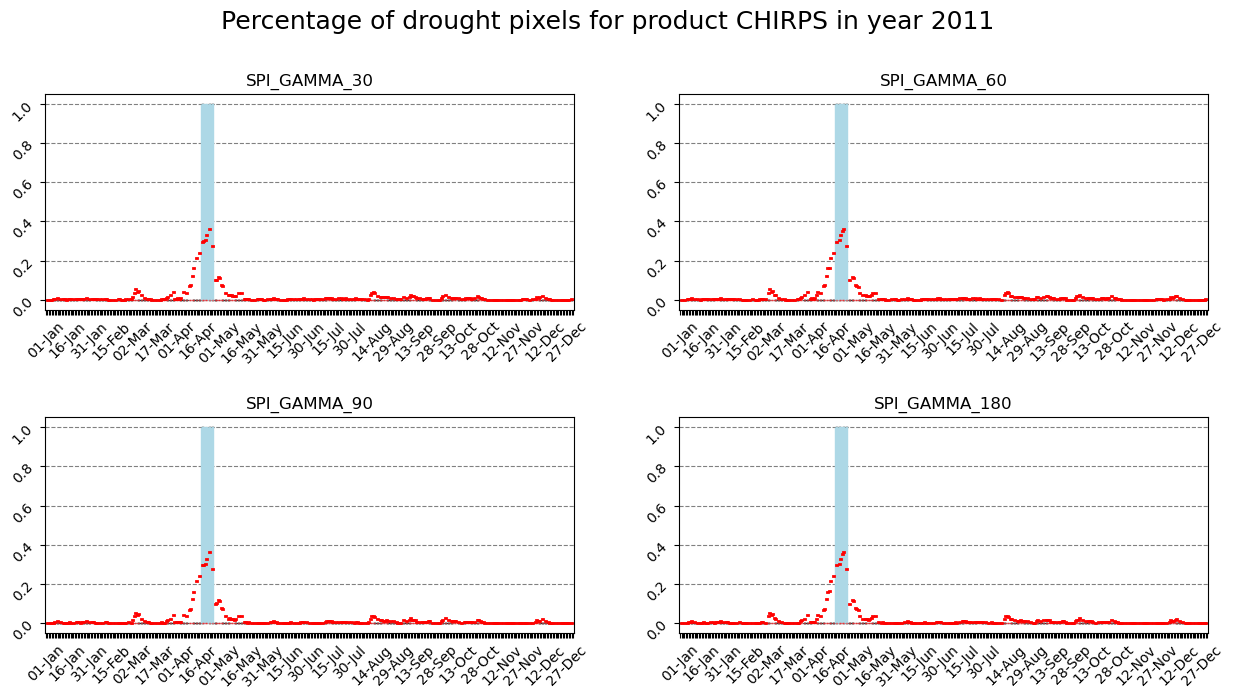

Plotting new product...


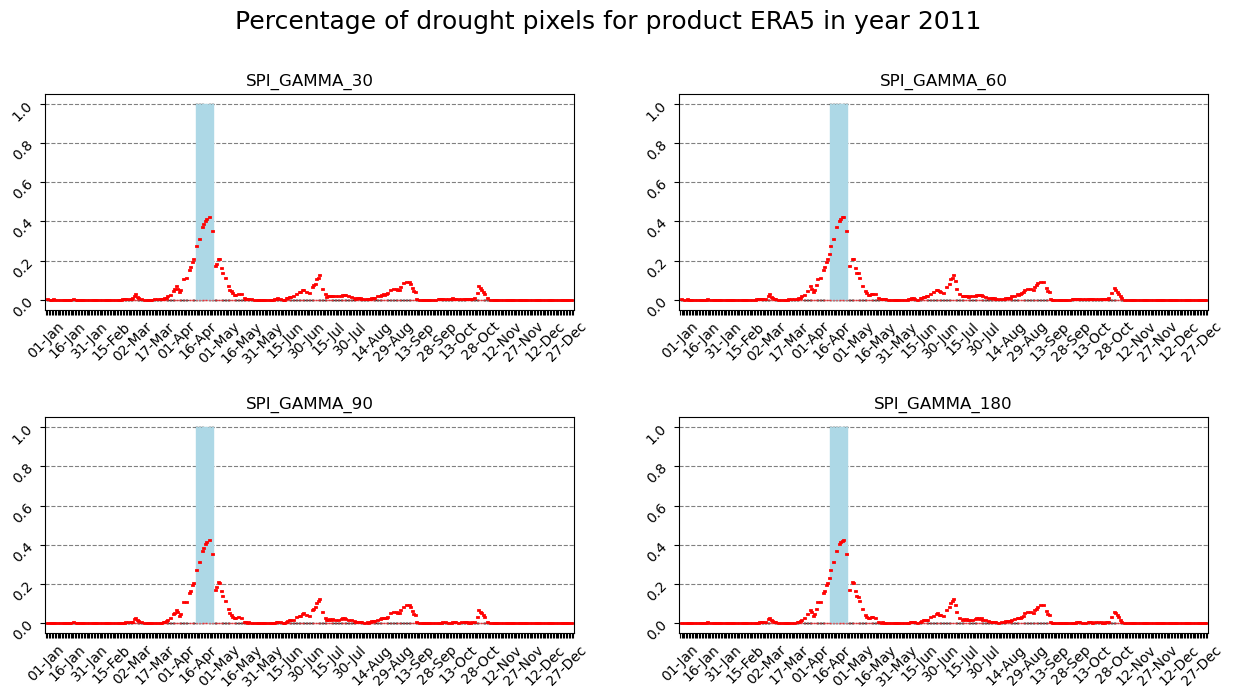

In [80]:
for year in [2009, 2010, 2011]:
    plot_products_drought_pixels(year)